In [1]:
#import matplotlib.pyplot as plt
import os
from py4j.java_gateway import JavaGateway
import numpy as np
import pandas as pd
import struct
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
#%matplotlib inline
import pickle
from utils import featurize_board, initialize_session_vars, Tetris, StateEncoder, PieceEncoder, play_game

In [2]:
from keras import callbacks
from keras import models
from keras import layers
import keras.backend as K
from keras.utils.np_utils import to_categorical
import tensorflow as tf

Using TensorFlow backend.


In [3]:
#from agents import DQN
#from actor_critic import Agent, PolicyGradient, ValueFunction, StateEncoder
#from agents import Agent, Boltzmann_distribution, DQN, DeepQNetwork
from boltzmann_distribution import BoltzmannDistribution
from value_function import ValueFunction
from pg_agent import PGAgent
import time

In [33]:
import matplotlib.pyplot as plt

In [34]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
tf.test.is_gpu_available()

True

In [6]:
from utils import bertsekas_features

# Initialize Tetris

In [8]:
gateway = JavaGateway()
tetris = gateway.entry_point.getState()
tetris = Tetris(tetris)
tetris.resetState()

True

# Initialize Session

In [9]:
sess = tf.Session()

# Initialize Variables

In [18]:
def play_game(tetris, feature_fn, theta, seed = None, verbose=False):
    
    if seed:
        tetris.resetState(seed)
    else:
        tetris.resetState()
        
    while not tetris.hasLost():
    
        scores = []
        moves = tetris.get_legal_moves()
        for orient, slot in moves:
            features = feature_fn(tetris, orient, slot)
            score = np.dot(features,theta)
            scores.append(score)

        action = int(np.argmax(scores))
        reward = tetris.makeMove(action)

        if verbose:
            if tetris.getTurnNumber() % verbose == 0:
                print('Lines cleared after {} turns: {}'.format(tetris.getTurnNumber(), tetris.getRowsCleared()))
    if verbose:
        print('Total lines cleared after {} turns: {}'.format(tetris.getTurnNumber(), tetris.getRowsCleared()))
        print('--------------------------------------------------------------------------------')
        
    return tetris.getRowsCleared()

In [19]:
def noisy_cross_entropy(mu, sigma, n_samples, n_features, rho, n_games, noise, score_fn, tetris, feature_fn, 
                        max_iter=1000, epsilon=0.01):
    
    converged = False
    n_iter = 0
    mean_rewards = []
    thetas = np.random.normal(mu, sigma, (n_samples, n_features))
    
    while not converged and n_iter < max_iter:
        rewards = []
        
        print('Iteration: {}'.format(n_iter+1))
        for i in range(n_samples):
            if i % 10 == 0:
                print('Running sample {}'.format(i))
            rewards.append(score_fn(tetris, feature_fn, thetas[i]))
            
        children = thetas[np.argsort(rewards)][-rho:]
        new_mu = np.mean(children, axis=0)
        
        converged = np.all(abs(new_mu - mu) < epsilon)
            
        mu = new_mu
        sigma = np.std(children, axis=0) + noise
        thetas = np.random.normal(mu, sigma, (n_samples, n_features))
        
        print('Calculating mean')
        reward = 0
        for i in range(n_games):
            if i % 5 == 0:
                print('Running mean sample {}'.format(i))
            reward += score_fn(tetris, feature_fn, mu)
            
        save_params(mu, sigma)
        mean_rewards.append(reward / n_games)
        
        n_iter += 1
        
        print('Average rows cleared after {} iterations: {}'.format(n_iter, mean_rewards[-1]))
        print('------------------------------------')
        print('------------------------------------')
        
        save_mean_rewards(mean_rewards)
        
    return mu, sigma, mean_rewards

In [12]:
def save_params(mu, sigma):
    with open('mu.pickle', 'wb') as mu_file:
        pickle.dump(mu, mu_file)
    with open('sigma.pickle', 'wb') as sigma_file:
        pickle.dump(sigma, sigma_file)

In [13]:
def save_mean_rewards(mean_rewards):
    if 'mean_rewards.pickle' not in os.listdir():
        with open('mean_rewards.pickle', 'wb') as rewards_file:
            pickle.dump(mean_rewards, rewards_file)
    else:
        with open('mean_rewards.pickle', 'rb') as rewards_file:
            old_mean_rewards = pickle.load(rewards_file)
        new_mean_rewards = old_mean_rewards + mean_rewards
        with open('mean_rewards.pickle', 'wb') as rewards_file:
            pickle.dump(new_mean_rewards, rewards_file)

In [14]:
def initialize_mu_sigma(n=15, size=9, init_mu=0, init_sigma=0.1):
    if 'mu.pickle' not in os.listdir():
        thetas = []
        rewards = []
        while len(thetas) < n:
            theta = np.random.normal(init_mu, init_sigma, size)
            reward = play_game(tetris, featurize_board, theta)
            if reward > 0:
                thetas.append(theta)
                rewards.append(reward)
                
        return np.mean(thetas, axis=0), np.std(thetas, axis=0)
    
    else:
        with open('mu.pickle', 'rb') as mu_file:
            mu = pickle.load(mu_file)
        with open('sigma.pickle', 'rb') as sigma_file:
            sigma = pickle.load(sigma_file)
            
        return mu, sigma

In [15]:
#input_dim = 217
#output_dim = 34
#buffer_size = 10000
#state_encoder = StateEncoder(7)
#theta = [-0.1263, 0.066, -0.0922, -0.1977, -0.1308, -0.1049, -0.0161, -0.2404, -0.75]
#nn_scaler = [21, 16, 180, 190, 100, 200, 100, 20, 2]

In [16]:
n_samples = 50
n_features = 9
rho = 10
n_games = 15
noise = 0.2
mu, sigma = initialize_mu_sigma(rho, n_features, 0, 0.1)

In [17]:
new_mu, new_sigma, mean_lines = noisy_cross_entropy(mu, sigma, n_samples, n_features, rho, n_games, 
                                                    noise, play_game, tetris, featurize_board, 1)

Iteration: 1
Running sample 0


C:\Users\Trace\Documents\MS\2019-01\CS8803\hw2\utils.py:129: RuntimeWarning: Mean of empty slice.
  landing_height = np.where(new_field==tetris.getTurnNumber()+1)[0].mean()
C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running sample 10
Running sample 20
Running sample 30


KeyboardInterrupt: 

In [28]:
mu, sigma = initialize_mu_sigma()
seeds = np.random.choice(range(1000), 15)
scores = []

In [29]:
for seed in seeds:
    score = play_game(tetris, featurize_board, mu, seed=int(seed), verbose=False)
    scores.append(score)
    print('Score for seed {}: {}'.format(seed, score))
    print('------------------------')

Score for seed 18: 529
------------------------
Score for seed 987: 5206
------------------------
Score for seed 643: 3371
------------------------
Score for seed 81: 17724
------------------------
Score for seed 425: 27090
------------------------
Score for seed 303: 8254
------------------------
Score for seed 351: 35107
------------------------
Score for seed 105: 2365
------------------------
Score for seed 335: 3661
------------------------
Score for seed 352: 16314
------------------------
Score for seed 918: 3060
------------------------
Score for seed 899: 38049
------------------------
Score for seed 385: 11893
------------------------
Score for seed 483: 6595
------------------------
Score for seed 942: 4914
------------------------


In [59]:
seeds = [18, 987, 643, 81, 25, 303, 351, 105, 335, 352, 918, 899, 385, 483, 942]
scores = [529, 5206, 3371, 17724, 27090, 8254, 35107, 2365, 3661, 16413, 3060, 38049, 11893, 6595, 4914]

In [43]:
np.mean(scores)

12282.066666666668

In [44]:
np.std(scores)

11773.42861682847

In [94]:
[str(seed) for seed in seeds]

['18',
 '987',
 '643',
 '81',
 '25',
 '303',
 '351',
 '105',
 '335',
 '352',
 '918',
 '899',
 '385',
 '483',
 '942']

In [103]:
len(str(scores[0]))

3

Text(0, 0.5, 'Weight')

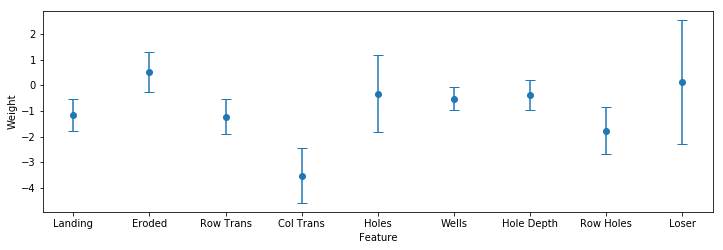

In [115]:
mu = [-1.14777939,  0.53152914, -1.22686743, -3.5132441 , -0.32098137,
       -0.51993179, -0.38084776, -1.76465347,  0.13229402]

theta = [0.63203014, 0.77998174, 0.68837408, 1.05511207, 1.5040822 ,
0.44690093, 0.58021795, 0.91264136, 2.41582657]



x = np.array(["Landing", "Eroded", "Row Trans", "Col Trans", "Holes", "Wells", "Hole Depth", "Row Holes", "Loser"])
plt.figure(figsize=(12,3.7))
plt.errorbar(x, mu, theta, capsize=5, linestyle='None', marker='o')
#plt.title("Feature Weights and Variances")
plt.xlabel("Feature")
plt.ylabel("Weight")

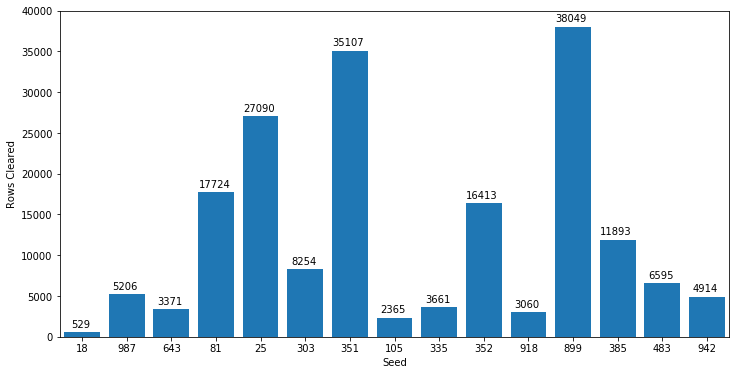

In [116]:
games = range(1, len(scores)+1)
plt.figure(figsize=(12,6))
plt.bar([str(seed) for seed in seeds], scores)
plt.xlim(-0.5, 14.5)
plt.ylim(0, 40000)
plt.xlabel('Seed')
plt.ylabel('Rows Cleared')
for game in games:
    x_adjust = (len(str(scores[game-1])) - 3) * 0.07
    plt.text(game-(1.25+x_adjust), scores[game-1] + 600, scores[game-1], color='black')
#plt.set_xticklabels([str(seed) for seed in seeds])

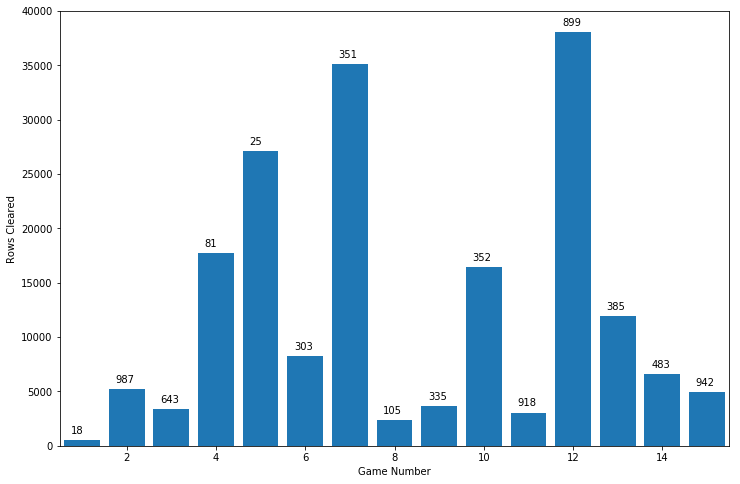

In [86]:
games = range(1, len(scores)+1)
plt.figure(figsize=(12,8))
plt.bar(x, scores)
plt.xlim(0.5, 15.5)
plt.ylim(0, 40000)
plt.xlabel('Game Number')
plt.ylabel('Rows Cleared')
for game in games:
    plt.text(game-0.25, scores[game-1] + 600, seeds[game-1], color='black')

In [45]:
with open('mean_rewards.pickle', 'rb') as rewards_file:
    mean_rewards = pickle.load(rewards_file)

Text(0, 0.5, 'Average Rows Cleared')

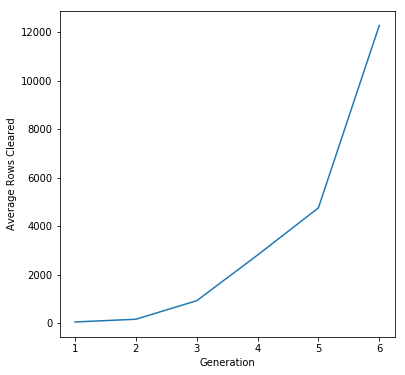

In [117]:
plt.figure(figsize=(6,6))
plt.plot(range(1, len(mean_rewards)+1), mean_rewards)
plt.xlabel('Generation')
plt.ylabel('Average Rows Cleared')

In [ ]:
seeds2 = np.random.choice(range(1000), 15)
scores2 = []

In [ ]:
for seed in seeds2:
    score = play_game(tetris, featurize_board, mu, seed=int(seed), verbose=False)
    scores2. append(score)
    print('Score for seed {}: {}'.format(seed, score))
    print('------------------------')

In [18]:
old_mean_rewards

[46.67, 158.86666666666667, 922.0666666666667, 2803.9333333333334, 4751.6]

In [13]:
mu

array([-0.98676746,  1.1203929 , -0.90676048, -2.95898922, -0.63081054,
       -0.43630121, -0.79420397, -1.47948168,  0.11039808])

In [1876]:
new_mu

array([-0.84479222,  0.69434807, -0.92145524, -2.39153106, -0.59405962,
       -0.64373012, -0.91903467, -1.0570921 ,  0.28562156])

In [ ]:
thetas = np.random.normal(mu, sigma, (n_samples, n_features))
mean_rewards = []

In [1641]:
rewards = []

for i in range(n_samples):
    rewards.append(play_game(tetris, bertsekas_features, thetas[i]))

children = thetas[np.argsort(rewards)[-rho:]]
new_mu = np.mean(children, axis=0)

mu = new_mu
sigma = np.std(children, axis=0) + noise
thetas = np.random.normal(mu, sigma, (n_samples, n_features))

reward = 0
for i in range(n_games):
    reward += play_game(tetris, bertsekas_features, mu)
mean_rewards.append(reward / n_games)
print('Average rows cleared after {} iterations: {}'.format(n_iter, mean_rewards[-1]))

Average rows cleared after 0 iterations: 0.0


In [1539]:
#tetris.resetState()
#while not tetris.hasLost():
for i in range(500):

    scores = []
    moves = tetris.get_legal_moves()
    for orient, slot in moves:
        features = featurize_board(tetris, orient, slot)
        score = np.dot(features,theta)
        scores.append(score)

    action = int(np.argmax(scores))
    reward = tetris.makeMove(action)

    if tetris.getTurnNumber() % 100 == 0:
        #agent.log_episode()
        #agent.train()
        print('Lines cleared after {} turns: {}'.format(tetris.getTurnNumber(), tetris.getRowsCleared()))
print('Total lines cleared after {} turns: {}'.format(tetris.getTurnNumber(), tetris.getRowsCleared()))
print('--------------------------------------------------------------------------------')

Lines cleared after 1100 turns: 436
Lines cleared after 1200 turns: 478
Lines cleared after 1300 turns: 517
Lines cleared after 1400 turns: 558
Lines cleared after 1500 turns: 596
Total lines cleared after 1500 turns: 596
--------------------------------------------------------------------------------


In [1540]:
tetris.get_board()

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,   

In [1541]:
tetris.getNextPiece()

5

In [1554]:
scores = []
features = []
moves = tetris.get_legal_moves()
for orient, slot in moves:
    feature = featurize_board(tetris, orient, slot)
    features.append(feature)
    score = np.dot(feature,theta)
    scores.append(score)

In [1555]:
list(zip(features, scores))

[(array([ 6.5,  0. , 24. , 18. ,  4. ,  2. , 11. ,  4. ,  0. ]), -8.46405),
 (array([ 5.5,  0. , 22. , 18. ,  4. ,  1. , 12. ,  4. ,  0. ]),
  -8.064549999999999),
 (array([ 4.5,  0. , 20. , 18. ,  4. ,  1. , 10. ,  4. ,  0. ]), -7.72165),
 (array([ 4.5,  0. , 22. , 18. ,  4. ,  6. , 11. ,  4. ,  0. ]), -8.44665),
 (array([ 3.5,  0. , 16. , 16. ,  3. ,  1. ,  9. ,  3. ,  0. ]), -6.44385),
 (array([ 5.5,  0. , 22. , 18. ,  4. ,  4. , 12. ,  3. ,  0. ]), -8.13885),
 (array([ 6.5,  0. , 26. , 18. ,  4. ,  8. , 12. ,  4. ,  0. ]),
  -9.293949999999999),
 (array([ 6.5,  0. , 24. , 18. ,  4. ,  2. , 12. ,  4. ,  0. ]), -8.48015),
 (array([ 6.,  0., 22., 14.,  2.,  2., 10.,  2.,  0.]), -6.667199999999999),
 (array([ 5.,  0., 22., 16.,  3.,  2., 12.,  3.,  0.]), -7.3397),
 (array([ 5.,  0., 26., 16.,  3.,  2., 10.,  3.,  0.]), -7.6763),
 (array([ 4.,  0., 22., 16.,  3.,  4., 10.,  3.,  0.]), -7.391),
 (array([ 4.,  0., 22., 16.,  3.,  2., 10.,  3.,  0.]), -7.1812000000000005),
 (array([ 5.,  0

In [1556]:
orient, slot = moves[11]#[np.argmax(scores)]
orient, slot

(1, 3)

In [1557]:
ROWS = tetris.getRows()
COLS = tetris.getCols()
piece = tetris.getNextPiece()
WIDTH = tetris.getpWidth()[piece][orient]
lost = False
rows_cleared = 0
eroded_piece_cells = 0
field = np.frombuffer(tetris.getByteArray(), dtype=np.int32)
new_field = np.array(field.reshape(21, 10))
piece = tetris.getNextPiece()
top = list(tetris.getTop())
max_height = max(top)

height = np.max(np.array(top[slot:slot+WIDTH]) - np.array(list(tetris.getpBottom()[piece][orient])[:WIDTH]))

if height + tetris.getpHeight()[piece][orient] >= tetris.getRows():
    lost = True

for i in range(WIDTH):
    for j in range(height+tetris.getpBottom()[piece][orient][i], min(21, height+tetris.getpTop()[piece][orient][i])):
        new_field[j][i+slot] = tetris.getTurnNumber() + 1

top[slot:slot+WIDTH] = list(tetris.getpTop()[piece][orient][:WIDTH]) + height

landing_height = np.min(np.where(new_field==tetris.getTurnNumber()+1)[0]) + (tetris.getpHeight()[piece][orient] / 2)

if not lost:
    # mask = np.all(new_field, axis=1)
    # rows_cleared = sum(mask)
    # new_field = np.concatenate([new_field[~mask], np.zeros((rows_cleared, 10))])
    # top = 21 - np.argmax(new_field[::-1, :], axis=0)
    # eroded_piece_cells = rows_cleared * (4 - sum(new_field.flatten() == tetris.getTurnNumber()+1))


    for r in range(min(ROWS-1, height + tetris.getpHeight()[piece][orient] - 1), height - 1, -1):
        full = True
        for c in range(COLS):
            if new_field[r][c] == 0:
                full = False
                break

        if full:
            rows_cleared += 1
            for c in range(COLS):
                for i in range(r, top[c]):
                    new_field[i][c] = new_field[i+1][c]
                top[c] -= 1
                while top[c] >= 1 and new_field[top[c]-1][c] == 0:
                    top[c] -= 1

    eroded_piece_cells = rows_cleared * (4 - sum(new_field.flatten() == tetris.getTurnNumber()+1))
    
max_height = max(top)

In [1558]:
new_field[::-1, :]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,   

In [1559]:
features[11]

array([ 4.,  0., 22., 16.,  3.,  4., 10.,  3.,  0.])

In [1574]:
from utils import bertsekas_features

In [1576]:
bertsekas_features(tetris, orient, slot)

[6, 5, 3, 6, 5, 3, 4, 6, 5, 5, 1, 2, 3, 1, 2, 1, 2, 1, 0, 6, 3]

In [1579]:
featurize_board(tetris, orient, slot)

array([ 4.,  0., 22., 16.,  3.,  4., 10.,  3.,  0.])

In [1570]:
holes

3

In [1572]:
f = list(tetris.getTop()) + list(abs(np.array(top)[:-1] - np.array(top)[1:])) + [max(top)] + [holes]

In [1577]:
f

[6, 5, 3, 4, 2, 3, 4, 6, 5, 5, 1, 2, 1, 2, 1, 1, 2, 1, 0, 6, 3]

In [1569]:
holes = 0
for i in range(max_height):
    for j in range(10):
        if new_field[i, j] == 0 and new_field[i+1, j] != 0:
            holes += 1

In [1480]:
holes = 0
row_holes = 0
hole_depth = 0
row_transitions = 0
for i in range(max_height):
    row_hole = False
    for j in range(10):
        if new_field[i, j] == 0:
            if j < 9 and new_field[i, j+1] != 0:
                row_transitions += 1
            if new_field[i+1, j] != 0:
                holes += 1
                row_hole = True
                hole_depth += 1
                counter = 2
                while i + counter < min(max_height, 20) and new_field[i+counter, j] != 0:
                    hole_depth += 1
                    counter += 1
        elif j < 9 and new_field[i, j] != 0 and new_field[i, j+1] == 0:
            row_transitions += 1
    if row_hole:
        row_holes += 1
row_transitions += sum(new_field[:max_height, 0] == 0)
row_transitions +=sum(new_field[:max_height, -1] == 0)

In [1481]:
holes, row_holes, hole_depth, row_transitions

(1, 1, 2, 18)

In [1536]:
ct = []
wells = 0
col_transitions = 0
for c in range(COLS):
    if c == 0:
        if top[c+1] > top[c]:
            wells += sum(range(top[c+1] - top[c] + 1))
            print(top[c], c)
    elif c == 9:
        if top[c-1] > top[c]:
            wells += sum(range(top[c-1] - top[c] + 1))
            print(top[c], c)
    else:
        if top[c+1] > top[c] and top[c-1] > top[c]:
            min_diff = min(top[c+1] - top[c], top[c-1] - top[c])
            wells += sum(range(min_diff + 1))
            print(top[c], c)
    for r in range(min(ROWS, max(top)+1)):
        if new_field[r, c] == 0:
            if r == 0:
                col_transitions += 1
                ct.append((r, c))
            if new_field[max(0, r-1), c] != 0:
                col_transitions += 1
                ct.append((r, c))
            if new_field[min(20, r+1), c] != 0:
                col_transitions += 1
                ct.append((r, c))

8 0
6 3


In [1386]:
top = list(tetris.getTop())
max_height = max(top)
field = np.frombuffer(tetris.getByteArray(), dtype=np.int32).reshape(21, 10)
new_field = np.array(field.reshape(21, 10))

In [1383]:
holes = 0
row_holes = 0
hole_depth = 0
row_transitions = 0
for i in range(max_height):
    row_hole = False
    for j in range(9):
        if field[i, j] == 0:
            if field[i, j+1] > 0:
                row_transitions += 1
            if field[i+1, j] != 0:
                holes += 1
                row_hole = True
                hole_depth += 1
                counter = 2
                while i + counter < min(max_height, 20) and new_field[i+counter, j] != 0:
                    hole_depth += 1
                    counter += 1
        elif field[i, j] > 0 and field[i, j+1] == 0:
            row_transitions += 1
    if row_hole:
        row_holes += 1
row_transitions += sum(field[:max_height, 0] == 0)
row_transitions +=sum(field[:max_height, -1] == 0)

0 1
2 1
2 1


In [1397]:
sum(field[0] == 0)

1

In [1372]:
new_field[2, 1] != 0

False

In [1373]:
new_field

array([[  0, 201,   0, 205, 209,   0, 210,   0, 204, 207],
       [  0,   0,   0,   0, 209,   0,   0,   0, 207, 207],
       [  0,   0,   0,   0,   0,   0,   0,   0, 207,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0

In [1339]:
ROWS = tetris.getRows()
COLS = tetris.getCols()
piece = tetris.getNextPiece()
WIDTH = tetris.getpWidth()[piece][orient]
lost = False
rows_cleared = 0
eroded_piece_cells = 0
field = np.frombuffer(tetris.getByteArray(), dtype=np.int32)
new_field = np.array(field.reshape(21, 10))
piece = tetris.getNextPiece()
top = list(tetris.getTop())


height = np.max(np.array(top[slot:slot+WIDTH]) - np.array(list(tetris.getpBottom()[piece][orient])[:WIDTH]))

if height + tetris.getpHeight()[piece][orient] >= tetris.getRows():
    lost = True

for i in range(WIDTH):
    for j in range(height+tetris.getpBottom()[piece][orient][i], min(21, height+tetris.getpTop()[piece][orient][i])):
        new_field[j][i+slot] = tetris.getTurnNumber() + 1

top[slot:slot+WIDTH] = list(tetris.getpTop()[piece][orient][:WIDTH]) + height

landing_height = np.min(np.where(new_field==tetris.getTurnNumber()+1)[0]) + (tetris.getpHeight()[piece][orient] / 2)

In [341]:
#start = time.time()
tetris.resetState(3)
#while not tetris.hasLost():
for i in range(250):
    scores = []
    moves = tetris.get_legal_moves()
    for orient, slot in moves:
        features = featurize_board(tetris, orient, slot)
        scores.append(np.dot(features,theta))
    action = int(np.argmax(scores))
    reward = tetris.makeMove(action)
    if tetris.getTurnNumber() % 100 == 0:
        print('Lines cleared after {} turns: {}'.format(tetris.getTurnNumber(), tetris.getRowsCleared()))
#time.time() - start

Lines cleared after 100 turns: 38
Lines cleared after 200 turns: 76


In [342]:
get_board(tetris)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 249],
       [250, 250,   0,   0,   0,   0, 245, 245, 249, 249

[4, 1, 1, 0, 0, 0, 0, 0, 2, 2]

In [ ]:
for i in range(10):
    

In [343]:
piece = tetris.getNextPiece()
piece

0

In [344]:
moves = tetris.get_legal_moves()

In [345]:
scores = []
for orient, slot in moves:
    features = featurize_board(tetris, orient, slot)
    scores.append(np.dot(features, theta))
    print(features)

[0.06 0.   0.12 0.11 0.01 0.01 0.04 0.01 0.  ]
[0.06 0.   0.14 0.13 0.02 0.04 0.04 0.02 0.  ]
[0.04 0.   0.1  0.11 0.01 0.03 0.02 0.01 0.  ]
[0.04 0.   0.12 0.13 0.02 0.04 0.04 0.01 0.  ]
[0.05 0.   0.12 0.13 0.02 0.   0.04 0.02 0.  ]
[0.06 0.   0.14 0.13 0.02 0.01 0.04 0.02 0.  ]
[0.06 0.   0.14 0.11 0.01 0.02 0.02 0.01 0.  ]
[0.06 0.   0.12 0.11 0.01 0.02 0.02 0.01 0.  ]
[0.07 0.   0.12 0.13 0.02 0.01 0.04 0.02 0.  ]


In [346]:
scores

[-0.045794,
 -0.058451,
 -0.0432,
 -0.051677,
 -0.051148,
 -0.055304000000000006,
 -0.048365,
 -0.046521,
 -0.054722999999999994]

In [261]:
np.argmax(scores)

21

In [262]:
moves[21]

[2, 4]

In [263]:
orient, slot = moves[21]

In [312]:
lost = False
rows_cleared = 0
field = np.frombuffer(tetris.getByteArray(), dtype=np.int32)
new_field = np.array(field.reshape(21, 10))
piece = tetris.getNextPiece()
top = list(tetris.getTop())

width = tetris.getpWidth()[piece][orient]
height = np.max(np.array(top[slot:slot+width]) - np.array(list(tetris.getpBottom()[piece][orient])[:width]))

if height + tetris.getpHeight()[piece][orient] >= tetris.getRows():
    lost = True

for i in range(tetris.getpWidth()[piece][orient]):
    for j in range(height+tetris.getpBottom()[piece][orient][i], min(21, height+tetris.getpTop()[piece][orient][i])):
        new_field[j][i+slot] = tetris.getTurnNumber() + 1

In [316]:
new_field

array([[249, 245, 251, 251, 252, 244, 244, 239, 243, 243],
       [249, 249, 251, 251, 252, 244, 244, 246, 243, 243],
       [249,   0,   0,   0, 252, 252, 246, 246, 247, 247],
       [  0,   0,   0,   0,   0,   0, 246, 248, 247, 247],
       [  0,   0,   0,   0,   0,   0, 248, 248, 250, 250],
       [  0,   0,   0,   0,   0,   0, 248,   0, 250, 250],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0

In [320]:
new_field[::-1, :]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 248,   0, 250, 250],
       [  0,   0,   0,   0,   0,   0, 248, 248, 250, 250

In [322]:
top

[3, 2, 2, 2, 3, 3, 6, 5, 6, 6]

In [323]:
21 - np.argmax(new_field[::-1, :], axis=0)

array([3, 2, 2, 2, 3, 3, 6, 5, 6, 6], dtype=int64)

In [309]:
for c in range(tetris.getpWidth()[piece][orient]):
    top[slot+c] = height + tetris.getpTop()[piece][orient][c]

In [321]:
top[slot:slot+width] = list(tetris.getpTop()[piece][orient][:width]) + height

In [296]:
mask = np.all(new_field, axis=1)

In [302]:
rows_cleared = sum(mask)

In [304]:
new_field = np.concatenate([new_field[~mask], np.zeros((rows_cleared, 10))])

In [301]:
sum(mask)

2

In [251]:
width = tetris.getpWidth()[piece][orient]
height = np.max(np.array(top[slot:slot+width]) - np.array(list(tetris.getpBottom()[piece][orient])[:width]))
height

17

In [191]:
if height + tetris.getpHeight()[piece][orient] >= tetris.getRows():
    lost = True

for i in range(tetris.getpWidth()[piece][orient]):
    for j in range(height+tetris.getpBottom()[piece][orient][i], min(21, height+tetris.getpTop()[piece][orient][i])):
        new_field[j][i+slot] = tetris.getTurnNumber() + 1

for c in range(tetris.getpWidth()[piece][orient]):
    top[slot+c] = height + tetris.getpTop()[piece][orient][c]

In [193]:
new_field[::-1, :]

array([[429, 429,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 429, 429,   0,   0,   0,   0,   0,   0,   0],
       [427, 427, 427, 427, 425, 425, 425, 426, 426,   0],
       [423, 423, 423, 423, 420, 419, 425, 421, 426,   0],
       [  0, 422, 422, 420, 420, 419, 421, 421, 426, 424],
       [417, 417, 415, 416, 416, 419, 414, 418, 424,   0],
       [379, 417, 380, 373, 368, 376,   0, 375, 375, 375],
       [374, 374, 374, 368, 368, 376,   0, 369, 372, 375],
       [  0, 349, 348, 348, 348, 346, 347, 347, 347, 347],
       [  0, 312, 315, 315, 314, 314, 314, 314, 313, 313],
       [  0, 312, 310, 315, 308, 311, 311, 309, 309, 307],
       [  0, 261, 256, 257, 257, 257, 263, 258, 260, 260],
       [  0, 249, 249, 241, 239, 240, 240, 254, 243, 243],
       [  0, 226, 227, 227, 227, 224, 233, 225, 228, 228],
       [  0, 226, 219, 222, 222, 224, 224, 225, 225, 228],
       [  0, 218, 219, 219, 222, 224, 221, 221, 225, 223],
       [  0, 215, 210, 208, 208, 207, 207, 211, 223, 214

In [208]:
np.min(np.where(new_field==tetris.getTurnNumber()+1)[0]) + (tetris.getpHeight()[piece][orient] / 2)

20.0

In [204]:
top

[21, 21, 20, 19, 19, 19, 19, 19, 19, 17]

In [188]:
top = list(tetris.getTop())
top

[19, 19, 19, 19, 19, 19, 19, 19, 19, 17]

In [205]:
piece_min_height = top[slot]
piece_min_height

21

In [206]:
if len(list(tetris.getpBottom()[piece][orient])) > 1:
    bottom_diff = max(list(tetris.getpBottom()[piece][orient])[1:]) - list(tetris.getpBottom()[piece][orient])[0]
    if bottom_diff < 0:
        
piece_min_height

IndentationError: expected an indented block (<ipython-input-206-16c81205a9d3>, line 5)

In [171]:
landing_height = piece_min_height + (tetris.getpHeight()[piece][orient] / 2)
landing_height

19.0

In [141]:
tetris.getpHeight()[piece][orient] // 2

2

In [151]:
sum(range(20)) * 5

950

In [27]:
lost = False
rows_cleared = 0
field = np.frombuffer(tetris.getByteArray(), dtype=np.int32)
new_field = np.array(field.reshape(21, 10))
piece = tetris.getNextPiece()
top = list(tetris.getTop())
curr_height = top[slot]
height = curr_height - tetris.getpBottom()[piece][orient][0]

for i in range(1, tetris.getpWidth()[piece][orient]):
    height = max(height, top[slot+i] - tetris.getpBottom()[piece][orient][i])

if height + tetris.getpHeight()[piece][orient] >= tetris.getRows():
    lost = True

for i in range(tetris.getpWidth()[piece][orient]):
    for j in range(height+tetris.getpBottom()[piece][orient][i], min(21, height+tetris.getpTop()[piece][orient][i])):
        new_field[j][i+slot] = tetris.getTurnNumber() + 1

for c in range(tetris.getpWidth()[piece][orient]):
    top[slot+c] = height + tetris.getpTop()[piece][orient][c]

In [29]:
new_field[::-1, :]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0, 5, 2],
       [0, 6, 3, 3, 0, 0, 7, 0, 5, 2],
       [0, 6, 3, 1, 4, 4, 7, 7, 5, 2],
       [6, 6, 1, 1, 1, 4, 4, 7, 5, 2]])

In [30]:
if not lost:
    for r in range(min(20, height + tetris.getpHeight()[piece][orient] - 1), height - 1, -1):
        full = True
        for c in range(tetris.getCols()):
            if new_field[r][c] == 0:
                full = False
                break

        if full:
            rows_cleared += 1
            for c in range(tetris.getCols()):
                for i in range(r, top[c]):
                    new_field[i][c] = new_field[i+1][c]
                top[c] -= 1
                while top[c] >= 1 and new_field[top[c]-1][c] == 0:
                    top[c] -= 1

In [31]:
new_field[::-1, :]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0, 5, 2],
       [0, 6, 3, 3, 0, 0, 7, 0, 5, 2],
       [0, 6, 3, 1, 4, 4, 7, 7, 5, 2]])

In [37]:
4 - sum(new_field.flatten() == tetris.getTurnNumber()+1)

1

In [44]:
holes = 0
row_holes = 0
hole_depth = 0
row_transitions = 0
for r in range(max(top)):
    row_hole = False
    for c in range(10):
        if new_field[r, c] == 0:
            if new_field[r, max(0, c-1)] != 0:
                row_transitions += 1
            if new_field[r, min(9, c+1)] != 0:
                row_transitions += 1
            if new_field[r+1, c] != 0:
                holes += 1
                hole_depth += 1
                i = 2
                while r+i < 20 and new_field[r+i, c] != 0:
                    hole_depth += 1
                    i += 1
                row_hole = True
    if row_hole:
        row_holes += 1

In [45]:
holes, row_holes, hole_depth, row_transitions

(0, 0, 0, 9)

In [51]:
wells = 0
col_transitions = 0
for c in range(10):
    if c == 0:
        if top[c+1] > top[c]:
            wells += sum(range(top[c+1] - top[c] + 1))
    elif c == 9:
        if top[c-1] > top[c]:
            wells += sum(range(top[c-1] - top[c] + 1))
    else:
        if top[c+1] > top[c] and top[c-1] > top[c]:
            min_diff = min(top[c+1] - top[c], top[c-1] - top[c])
            wells += sum(range(min_diff + 1))
    for r in range(max(top)+1):
        if new_field[r, c] == 0:
            if new_field[max(0, r-1), c] != 0:
                col_transitions += 1
            if new_field[min(20, r+1), c] != 0:
                col_transitions += 1

In [52]:
wells, col_transitions

(4, 9)

In [71]:
min(max(list(tetris.getpBottom()[5][1])[1:]) - list(tetris.getpBottom()[5][1])[0], 0)

-1

In [69]:
tetris.getpHeight()[5][1] // 2

1

# Generate Training Data

In [763]:
dqn = DeepQNetwork(sess, input_dim, output_dim, buffer_size, state_encoder)
initialize_session_vars(sess)

In [821]:
states = []
targets = []
actions = []
for i in range(1):
    tetris.resetState()
    episode_rewards = []
    while not tetris.hasLost():
        scores = []
        rewards = []
        moves = get_legal_moves(tetris)
        for orient, slot in moves:
            reward, score = score_move(tetris, orient, slot, theta)
            rewards.append(reward)
            scores.append(score)
        states.append(state_encoder.transform(tetris))
        episode_rewards.append(np.concatenate([rewards, np.zeros(34-len(rewards))]))
        action = int(np.argmax(scores))
        actions.append(action)
        reward = tetris.makeMove(action)
    discounted_rewards = np.array(episode_rewards)
    for i in range(len(discounted_rewards)-2, -1, -1):
        discounted_rewards[i, :] += 0.9 * max(discounted_rewards[i+1, :])
    targets += list(discounted_rewards)
#df = pd.DataFrame(np.concatenate([np.array(states).reshape(-1, 217), np.array(targets), np.array(actions)], axis=1))

In [817]:
dqn.initialize(np.array(states).reshape(-1, 217), np.max(np.array(targets), axis=1), np.array(actions))

In [818]:
preds = dqn.predict(np.array(states).reshape(-1, 217))

In [819]:
preds[0]

array([-0.04479671, -0.01192509,  0.00071757,  0.02022365, -0.01954975,
        0.00508687, -0.00579076, -0.04067556, -0.02199614, -0.03448485,
       -0.03599149, -0.01360015, -0.01310019, -0.05736088,  0.00382666,
       -0.00399606,  0.00339455,  0.01800025,  0.0063331 , -0.00970786,
        0.02769281,  0.06658262, -0.02684166, -0.00032151,  0.00148026,
       -0.01053088, -0.04539678, -0.0075624 , -0.00444068,  0.00556024,
       -0.00946494,  0.01201106, -0.01097792, -0.0142971 ], dtype=float32)

In [820]:
targets[0]

array([0.27427774, 0.27427774, 0.27427774, 0.27427774, 0.27427774,
       0.27427774, 0.27427774, 0.27427774, 0.27427774, 0.27427774,
       0.27427774, 0.27427774, 0.27427774, 0.27427774, 0.27427774,
       0.27427774, 0.27427774, 0.27427774, 0.27427774, 0.27427774,
       0.27427774, 0.27427774, 0.27427774, 0.27427774, 0.27427774,
       0.27427774, 0.27427774, 0.27427774, 0.27427774, 0.27427774,
       0.27427774, 0.27427774, 0.27427774, 0.27427774])

In [816]:
actions[0]

0

In [785]:
max(preds[0])

0.05655116

In [786]:
np.argmax(preds[0])

21

In [739]:
df = generate_training_data(50, tetris, theta, state_encoder)

In [740]:
#df.to_csv('training_data.csv', index=False)

In [1032]:
#update_training_data(df)

# Boltzmann PG

In [978]:
boltz = BoltzmannDistribution(input_dim, output_dim, theta)
value  = ValueFunction(sess, 9)
initialize_session_vars(sess)
pg_agent = PGAgent(9, featurize_board, boltz, value) 

In [116]:
from actor_critic import Agent, PolicyGradient, ValueFunction
from utils import StateEncoder

In [952]:
state_encoder = StateEncoder(7)

In [1239]:
value_function = ValueFunction(sess, 217, learning_rate=0.001)

In [1240]:
policy = PolicyGradient(sess, 217, 34, learning_rate=0.001)

In [1244]:
agent = Agent(sess, 217, 34, state_encoder, policy, value_function)

In [1243]:
for i in range(10):
    tetris.resetState()
    while not tetris.hasLost():
    #for i in range(200):

        scores = []
        moves = tetris.get_legal_moves()
        for orient, slot in moves:
            features = featurize_board(tetris, orient, slot)
            score = np.dot(features,theta)
            scores.append(score)
            
        state = agent.encode_state(tetris)
        action = int(np.argmax(scores))
        reward = tetris.makeMove(action)
        next_state = agent.encode_state(tetris)
        done = tetris.hasLost()
        agent.log_experience(state, action, reward, next_state, done)
        
        if tetris.getTurnNumber() % 100 == 0:
            #agent.log_episode()
            #agent.train()
            print('Lines cleared after {} turns: {}'.format(tetris.getTurnNumber(), tetris.getRowsCleared()))
    print('Total lines cleared after {} turns: {}'.format(tetris.getTurnNumber(), tetris.getRowsCleared()))
    print('--------------------------------------------------------------------------------')
    
    agent.log_episode()
agent.train()

KeyboardInterrupt: 

In [1257]:
for i in range(10):
    tetris.resetState(10)
    while not tetris.hasLost():
            
        state = agent.encode_state(tetris)
        #action = agent.choose_action(tetris, state)
        action = agent.choose_action(tetris, state)
        reward = tetris.makeMove(action)
        next_state = agent.encode_state(tetris)
        done = tetris.hasLost()
        agent.log_experience(state, action, reward, next_state, done)
        
        if tetris.getTurnNumber() % 100 == 0:
            print('Lines cleared after {} turns: {}'.format(tetris.getTurnNumber(), tetris.getRowsCleared()))
    print('Total lines cleared after {} turns: {}'.format(tetris.getTurnNumber(), tetris.getRowsCleared()))
    print('--------------------------------------------------------------------------------')
    
    agent.log_episode()
agent.train()

ValueError: probabilities contain NaN

In [950]:
agent.train()

In [949]:
states = agent.states
actions = agent.actions
rewards = agent.rewards

In [956]:
actions_onehot = tf.reduce_sum(agent.policy.output * tf.one_hot(agent.policy.actions_, agent.policy.output_dim), reduction_indices=[1])
action_probs = tf.log(actions_onehot)
p_loss = -tf.reduce_sum(agent.policy.advantages * action_probs)
v_loss = tf.reduce_sum(tf.square(agent.value_function.labels - agent.value_function.output))

In [1205]:
i = 5

In [1206]:
advantages, discounted_rewards = agent.calc_advantages_discounted_rewards(states[i], rewards[i])

In [1227]:
sess.run(actions_onehot, feed_dict={agent.policy.inputs: np.array(states[i]).reshape(-1, agent.input_dim),
                                                       agent.policy.actions_: actions[i]})

array([0.03479755, 0.02099057, 0.00668604, ..., 0.08225767, 0.05651617,
       0.00109531], dtype=float32)

In [1228]:
sess.run(action_probs, feed_dict={agent.policy.inputs: np.array(states[i]).reshape(-1, agent.input_dim),
                                                       agent.policy.actions_: actions[i]})

array([-3.3582084, -3.8636818, -5.0077333, ..., -2.4978986, -2.8732285,
       -6.816718 ], dtype=float32)

In [1229]:
sess.run([p_loss, agent.policy.train_op], feed_dict={agent.policy.inputs: np.array(states[i]).reshape(-1, agent.input_dim),
                                                     agent.policy.actions_: np.array(actions[i]),
                                                     agent.policy.advantages: advantages})

[-390.32913, None]

In [1230]:
sess.run([v_loss, agent.value_function.train_op], feed_dict={agent.value_function.inputs: np.array(states[i]).reshape(-1, agent.input_dim),
                                                             agent.value_function.labels: discounted_rewards})

[116340.62, None]

In [1231]:
agent.policy.predict(np.array(states[i]).reshape(-1, agent.input_dim))[100]

array([0.02004332, 0.03201703, 0.04556061, 0.04002338, 0.02689831,
       0.01675648, 0.02510888, 0.00628932, 0.00572373, 0.00967838,
       0.01864521, 0.04683416, 0.02571737, 0.02951609, 0.03323856,
       0.01174307, 0.0094664 , 0.01837593, 0.01194524, 0.03622409,
       0.04867753, 0.01292391, 0.02673158, 0.02765157, 0.04273937,
       0.05235323, 0.04835633, 0.05005619, 0.03132233, 0.03961139,
       0.04560292, 0.02298516, 0.04300753, 0.0381754 ], dtype=float32)

In [1232]:
actions[i][100]

9

In [1233]:
agent.value_function.predict(np.array(states[i]).reshape(-1, agent.input_dim))[100]

array([0.36060566], dtype=float32)

In [1234]:
discounted_rewards[100]

0.41428944938655865

In [1235]:
np.argmax(agent.policy.predict(np.array(states[i]).reshape(-1, agent.input_dim))[100])

25

In [387]:
#agent.train()

In [769]:
value_states = []
value_returns = []
pg_states = []
pg_targets = []

In [770]:
for i in range(1):
    #state = np.zeros(9)
    tetris.resetState(3)
    rewards = []
    while not tetris.hasLost():
    #for i in range(150):

        scores = []
        moves = tetris.get_legal_moves()
        for orient, slot in moves:
            features = featurize_board(tetris, orient, slot)
            score = np.dot(features,theta)
            scores.append(score)
            pg_states.append(features)
            pg_targets.append(score)

        action = pg_agent.choose_best_action(tetris)
        #action = pg_agent.choose_action(tetris)
        #next_state = pg_agent.encode_state(tetris, tetris.get_legal_moves()[action])
        state = pg_agent.encode_state(tetris, tetris.get_legal_moves()[action])
        reward = tetris.makeMove(action)
        rewards.append(reward)
        pg_agent.log_experience(state, reward)
        #state = next_state
        value_states.append(state)
        if tetris.getTurnNumber() % 100 == 0:
            print('Lines cleared after {} turns: {}'.format(tetris.getTurnNumber(), tetris.getRowsCleared()))

    discounted_rewards = np.array(rewards)
    for j in range(len(discounted_rewards)-2, -1, -1):
        discounted_rewards[j] += 0.9 * discounted_rewards[j+1]    
    value_returns.append(discounted_rewards)

    pg_agent.log_episode()
    pg_agent.update()
    
#     with open('value_states.pickle', 'wb') as vsp:
#         pickle.dump(value_states, vsp)
#     with open('value_returns.pickle', 'wb') as vrp:
#         pickle.dump(value_returns, vrp)
#     with open('pg_states.pickle', 'wb') as pgs:
#         pickle.dump(pg_states, pgs)
#     with open('pg_targets.pickle', 'wb') as pgt:
#         pickle.dump(pg_targets, pgt)

Lines cleared after 100 turns: 38
Lines cleared after 200 turns: 76


KeyboardInterrupt: 

In [773]:
standard = StandardScaler()
minmax = MinMaxScaler()

In [775]:
from policy_model import PolicyModel

In [813]:
policy_batch_gen = batch_generator(minmax.fit_transform(pg_states), pg_targets, 256)

In [818]:
pm = PolicyModel(sess, 9)
initialize_session_vars(sess)

In [831]:
for i in range(10):
    for batch in range(len(pg_states) // 256):
        x_batch, y_batch = next(policy_batch_gen)
        pm.train(x_batch, y_batch)

In [843]:
pm.predict(minmax.transform(pg_states[:10])).reshape(-1,)

array([-1.8369532, -1.8346908, -1.8274199, -1.8274199, -1.8274199,
       -1.8274199, -1.8492327, -1.8296824, -1.9066808, -1.9457816],
      dtype=float32)

In [844]:
pm.predict(minmax.transform(pg_states[-10:])).reshape(-1,)

array([-4.7911153, -4.58698  , -3.2814982, -3.9325483, -3.0623267,
       -3.765572 , -3.772654 , -2.9378428, -3.6124852, -4.319415 ],
      dtype=float32)

In [841]:
np.array(pg_targets[:10])

array([-1.6859 , -1.7781 , -1.6732 , -1.6732 , -1.6732 , -1.6732 ,
       -1.9879 , -1.581  , -1.55475, -2.36855])

In [842]:
np.array(pg_targets[-10:])

array([-6.5731 , -6.3253 , -4.93185, -5.97505, -4.88165, -5.74385,
       -5.84875, -5.27985, -5.06435, -7.17175])

In [840]:
minmax.transform(pg_states[:10])

array([[0.05263158, 0.        , 0.        , 0.05555556, 0.16666667,
        0.02777778, 0.07142857, 0.33333333, 0.        ],
       [0.05263158, 0.        , 0.04545455, 0.05555556, 0.16666667,
        0.02777778, 0.07142857, 0.33333333, 0.        ],
       [0.05263158, 0.        , 0.04545455, 0.05555556, 0.16666667,
        0.        , 0.07142857, 0.33333333, 0.        ],
       [0.05263158, 0.        , 0.04545455, 0.05555556, 0.16666667,
        0.        , 0.07142857, 0.33333333, 0.        ],
       [0.05263158, 0.        , 0.04545455, 0.05555556, 0.16666667,
        0.        , 0.07142857, 0.33333333, 0.        ],
       [0.05263158, 0.        , 0.04545455, 0.05555556, 0.16666667,
        0.        , 0.07142857, 0.33333333, 0.        ],
       [0.05263158, 0.        , 0.04545455, 0.05555556, 0.16666667,
        0.08333333, 0.07142857, 0.33333333, 0.        ],
       [0.05263158, 0.        , 0.        , 0.05555556, 0.16666667,
        0.        , 0.07142857, 0.33333333, 0.        ],


In [838]:
minmax.transform(pg_states[-10:])

array([[0.68421053, 0.        , 0.45454545, 0.66666667, 0.5       ,
        0.08333333, 0.42857143, 1.        , 0.        ],
       [0.78947368, 0.        , 0.5       , 0.66666667, 0.5       ,
        0.02777778, 0.35714286, 0.66666667, 0.        ],
       [0.63157895, 0.        , 0.5       , 0.44444444, 0.16666667,
        0.05555556, 0.28571429, 0.33333333, 0.        ],
       [0.63157895, 0.        , 0.63636364, 0.55555556, 0.33333333,
        0.05555556, 0.28571429, 0.66666667, 0.        ],
       [0.52631579, 0.        , 0.54545455, 0.44444444, 0.16666667,
        0.05555556, 0.21428571, 0.33333333, 0.        ],
       [0.52631579, 0.        , 0.63636364, 0.55555556, 0.33333333,
        0.02777778, 0.28571429, 0.66666667, 0.        ],
       [0.52631579, 0.        , 0.63636364, 0.55555556, 0.33333333,
        0.05555556, 0.28571429, 0.66666667, 0.        ],
       [0.42105263, 0.        , 0.54545455, 0.44444444, 0.16666667,
        0.19444444, 0.21428571, 0.33333333, 0.        ],


In [711]:
from value_function import ValueFunction

In [796]:
#value_returns = [val for sublist in value_returns for val in sublist]
discounted_rewards = np.array(rewards)
for j in range(len(discounted_rewards)-2, -1, -1):
    discounted_rewards[j] += 0.9 * discounted_rewards[j+1]    
value_returns.append(list(discounted_rewards))

In [715]:
value_batch_gen = batch_generator(minmax.fit_transform(value_states), value_returns, 256)

In [716]:
vm = ValueFunction(sess, 9)
initialize_session_vars(sess)

In [724]:
for i in range(100):
    for batch in range(len(value_states) // 256):
        x_batch, y_batch = next(value_batch_gen)
        vm.train(x_batch, y_batch)

In [722]:
vm.predict(value_scaler.fit_transform(value_states)[10:20]).reshape(-1,)

array([0.36392683, 0.40501943, 0.39443734, 0.3914276 , 0.39243573,
       0.4018831 , 0.39314196, 0.39815873, 0.39987335, 0.40044615],
      dtype=float32)

In [723]:
np.array(value_returns[10:20])

array([0.56640291, 0.62933656, 0.47704063, 0.41893403, 0.35437114,
       0.39374571, 0.43749524, 0.48610582, 0.42900647, 0.36556274])

In [725]:
len(value_returns)

83411

In [988]:
value.train()

In [942]:
for i in range(1):
    lines_cleared = []
    for j in range(10):
        state = np.zeros()
        tetris.resetState()
        while not tetris.hasLost():
            action = int(boltz.choose_best_action(tetris))
            reward = tetris.makeMove(action)
            boltz.log_reward(reward)
        boltz.log_episode()
        lines_cleared.append(tetris.getRowsCleared())
    print('Average lines cleared: {}'.format(np.mean(lines_cleared)))
    boltz.update_theta()

Average lines cleared: 420.7


In [972]:
len(value.predict(value.states[0]))

558

In [973]:
len(discounted_rewards)

558

In [975]:
value.states[0]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0, 0, 7, 7, 3, 0, 6, 3, 0]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0, 0, 4, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 6, 4, 1, 1, 2, 1, 0]),
 array([2, 0, 8, 4, 1, 3, 2, 1, 0]),
 array([4, 0, 7, 4, 1, 0, 2, 1, 0]),
 array([0, 0, 9, 6, 1, 0, 2, 1, 0]),
 array([ 3,  0, 11,  6,  1,  1,  3,  1,  0]),
 array([ 4,  0, 11,  6,  1,  0,  7,  1,  0]),
 array([ 0,  0, 13,  9,  2,  0,  9,  1,  0]),
 array([ 2,  0, 11,  9,  2,  0,  9,  1,  0]),
 array([ 3,  1, 10,  9,  2,  0,  8,  1,  0]),
 array([ 4,  0, 10,  9,  2,  0,  8,  1,  0]),
 array([ 0,  1, 10, 10,  2,  0,  6,  1,  0]),
 array([0, 1, 9, 9, 1, 0, 4, 1, 0]),
 array([0, 1, 8, 9, 1, 0, 3, 1, 0]),
 array([ 0,  0,  8, 11,  1,  1,  3,  1,  0]),
 array([ 1,  0,  8, 11,  1,  1,  3,  1,  0]),
 array([ 2,  1,  8, 11,  1,  1,  2,  1,  0]),
 array([ 1,  0,  8, 11,  1,  2,  2,  1,  0]),
 array([ 1,  1,  8, 11,  1,  2,  1,  1,  0]),
 array([ 1,  0,  8, 11,  1,  3,  1,  1,  0]),
 array([ 2,  0

In [943]:
theta

[-0.1263, 0.066, -0.0922, -0.1977, -0.1308, -0.1049, -0.0161, -0.2404, -0.75]

In [944]:
boltz.theta

array([-0.14404378,  0.07055377, -0.18590242, -0.23976062, -0.15174713,
       -0.13495973, -0.04825843, -0.25863899, -0.74893179])

In [ ]:
    discounted_rewards = np.array(episode_rewards)
    for i in range(len(discounted_rewards)-2, -1, -1):
        discounted_rewards[i, :] += 0.9 * max(discounted_rewards[i+1, :])

In [922]:
new_theta = list(theta)

In [923]:
for t in range(len(boltz.rewards[0])):
    g = 0
    for k in range(t+1, len(boltz.rewards[0])):
        g += 0.9 ** (k-t-1) * boltz.rewards[0][k]
    new_theta = new_theta + 0.001 * 0.9 ** t * g * boltz.gradients[0][t]

In [924]:
new_theta

array([-0.12638714,  0.06599328, -0.09231005, -0.19785796, -0.13089617,
       -0.10487279, -0.01622562, -0.24044578, -0.7499991 ])

In [925]:
theta

[-0.1263, 0.066, -0.0922, -0.1977, -0.1308, -0.1049, -0.0161, -0.2404, -0.75]

In [926]:
boltz.theta

array([-0.12773928,  0.06618096, -0.09341876, -0.19848288, -0.13113328,
       -0.10411105, -0.01682263, -0.24070528, -0.7500091 ])

In [921]:
total_reward = sum(boltz.rewards[0])
np.sum(np.array(boltz.gradients[0]) * total_reward, axis=0)

array([-2.82631132,  0.35962038, -1.7034233 , -2.89662037, -1.63359028,
       -2.05878626, -4.97965134, -0.62539765,  0.08857105])

In [843]:
state = np.zeros(9)

In [855]:
tetris.getNextPiece()

2

In [846]:
moves = tetris.get_legal_moves()
moves

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [1, 0],
 [1, 1],
 [1, 2],
 [1, 3],
 [1, 4],
 [1, 5],
 [1, 6],
 [1, 7],
 [2, 0],
 [2, 1],
 [2, 2],
 [2, 3],
 [2, 4],
 [2, 5],
 [2, 6],
 [2, 7],
 [2, 8],
 [3, 0],
 [3, 1],
 [3, 2],
 [3, 3],
 [3, 4],
 [3, 5],
 [3, 6],
 [3, 7]]

In [847]:
action_states = np.array([boltz.encode_state(tetris, move) for move in moves]).T

In [854]:
(np.matmul(boltz.theta, action_states))

array([-0.672 , -1.578 , -0.9486, -0.9486, -0.9486, -0.9486, -0.9486,
       -1.0535, -1.1711, -1.7071, -2.2062, -1.8915, -1.8915, -1.8915,
       -1.8915, -2.2062, -1.7993, -1.4414, -2.163 , -1.5336, -1.5336,
       -1.5336, -1.5336, -1.5336, -2.163 , -1.257 , -0.8697, -1.0668,
       -0.9619, -0.9619, -0.9619, -0.9619, -1.2766, -0.7775])

In [856]:
probs = np.exp(np.matmul(boltz.theta, action_states))

In [860]:
probs /= sum(probs)

In [867]:
action_states[:, 3] - np.sum(probs * action_states, axis=1)

array([ 0.        ,  0.        ,  1.41286083, -0.8960299 , -0.44640336,
       -0.61422578, -0.44640336, -0.32112908,  0.        ])

In [ ]:
episode_rewards = []
scores = []
rewards = []
moves = get_legal_moves(tetris)
for orient, slot in moves:
    reward, score = score_move(tetris, orient, slot, theta)
    rewards.append(reward)
    scores.append(score)
states.append(state_encoder.transform(tetris))
episode_rewards.append(np.concatenate([rewards, np.zeros(34-len(rewards))]))
action = int(np.argmax(scores))
actions.append(action)
reward = tetris.makeMove(action)

In [ ]:
discounted_rewards = np.array(episode_rewards)
for i in range(len(discounted_rewards)-2, -1, -1):
    discounted_rewards[i, :] += 0.9 * max(discounted_rewards[i+1, :])
targets += list(discounted_rewards)

# Deep Q Network

In [744]:
data = pd.read_csv('training_data.csv')
x = data.values[:, :-34]
y = data.values[:, -34:]
#x = np.array(examples)
#y = np.array(discounted_rewards)

In [705]:
#scaler = StandardScaler()
scaler = MinMaxScaler()

In [706]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [707]:
x_train = scaler.fit_transform(x_train.astype(float))
x_test = scaler.transform(x_test.astype(float))

In [708]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [709]:
early_stopping = callbacks.EarlyStopping(monitor='mean_absolute_error', patience=5, verbose=0, mode='auto')

In [710]:
dqn = DeepQNetwork(sess, input_dim, output_dim, buffer_size, state_encoder)

In [711]:
initialize_session_vars(sess)

In [712]:
dqn.initialize(x_train, y_train, 200, 256, (x_test, y_test), [early_stopping])

Train on 221 samples, validate on 70 samples
Epoch 1/200
221/221 [==============================] - 2s 7ms/step - loss: 15.3520 - mean_absolute_error: 3.7173 - val_loss: 14.9597 - val_mean_absolute_error: 3.5967
Epoch 2/200
221/221 [==============================] - 0s 0us/step - loss: 14.6708 - mean_absolute_error: 3.6216 - val_loss: 14.4021 - val_mean_absolute_error: 3.5210
Epoch 3/200
221/221 [==============================] - 0s 71us/step - loss: 14.0832 - mean_absolute_error: 3.5348 - val_loss: 13.6770 - val_mean_absolute_error: 3.4214
Epoch 4/200
221/221 [==============================] - 0s 0us/step - loss: 13.3179 - mean_absolute_error: 3.4177 - val_loss: 12.7826 - val_mean_absolute_error: 3.2963
Epoch 5/200
221/221 [==============================] - 0s 71us/step - loss: 12.3735 - mean_absolute_error: 3.2609 - val_loss: 11.8418 - val_mean_absolute_error: 3.1485
Epoch 6/200
221/221 [==============================] - 0s 0us/step - loss: 11.3660 - mean_absolute_error: 3.0774 - val

Epoch 50/200
221/221 [==============================] - 0s 71us/step - loss: 0.2516 - mean_absolute_error: 0.3684 - val_loss: 0.4816 - val_mean_absolute_error: 0.5028
Epoch 51/200
221/221 [==============================] - 0s 0us/step - loss: 0.2375 - mean_absolute_error: 0.3564 - val_loss: 0.4717 - val_mean_absolute_error: 0.4909
Epoch 52/200
221/221 [==============================] - 0s 71us/step - loss: 0.2254 - mean_absolute_error: 0.3444 - val_loss: 0.4587 - val_mean_absolute_error: 0.4807
Epoch 53/200
221/221 [==============================] - 0s 0us/step - loss: 0.2145 - mean_absolute_error: 0.3351 - val_loss: 0.4402 - val_mean_absolute_error: 0.4724
Epoch 54/200
221/221 [==============================] - 0s 73us/step - loss: 0.2033 - mean_absolute_error: 0.3270 - val_loss: 0.4250 - val_mean_absolute_error: 0.4651
Epoch 55/200
221/221 [==============================] - 0s 31us/step - loss: 0.1934 - mean_absolute_error: 0.3192 - val_loss: 0.4144 - val_mean_absolute_error: 0.4560


Epoch 100/200
221/221 [==============================] - 0s 0us/step - loss: 0.0320 - mean_absolute_error: 0.1275 - val_loss: 0.1836 - val_mean_absolute_error: 0.3058
Epoch 101/200
221/221 [==============================] - 0s 71us/step - loss: 0.0307 - mean_absolute_error: 0.1246 - val_loss: 0.1803 - val_mean_absolute_error: 0.3055
Epoch 102/200
221/221 [==============================] - 0s 0us/step - loss: 0.0294 - mean_absolute_error: 0.1220 - val_loss: 0.1807 - val_mean_absolute_error: 0.3029
Epoch 103/200
221/221 [==============================] - 0s 0us/step - loss: 0.0282 - mean_absolute_error: 0.1193 - val_loss: 0.1768 - val_mean_absolute_error: 0.3018
Epoch 104/200
221/221 [==============================] - 0s 71us/step - loss: 0.0269 - mean_absolute_error: 0.1168 - val_loss: 0.1767 - val_mean_absolute_error: 0.2992
Epoch 105/200
221/221 [==============================] - 0s 0us/step - loss: 0.0258 - mean_absolute_error: 0.1143 - val_loss: 0.1747 - val_mean_absolute_error: 0.2

Epoch 149/200
221/221 [==============================] - 0s 0us/step - loss: 0.0064 - mean_absolute_error: 0.0591 - val_loss: 0.1630 - val_mean_absolute_error: 0.2799
Epoch 150/200
221/221 [==============================] - 0s 71us/step - loss: 0.0060 - mean_absolute_error: 0.0573 - val_loss: 0.1659 - val_mean_absolute_error: 0.2797
Epoch 151/200
221/221 [==============================] - 0s 0us/step - loss: 0.0057 - mean_absolute_error: 0.0554 - val_loss: 0.1651 - val_mean_absolute_error: 0.2793
Epoch 152/200
221/221 [==============================] - 0s 0us/step - loss: 0.0055 - mean_absolute_error: 0.0546 - val_loss: 0.1645 - val_mean_absolute_error: 0.2792
Epoch 153/200
221/221 [==============================] - 0s 71us/step - loss: 0.0054 - mean_absolute_error: 0.0543 - val_loss: 0.1669 - val_mean_absolute_error: 0.2794
Epoch 154/200
221/221 [==============================] - 0s 0us/step - loss: 0.0055 - mean_absolute_error: 0.0544 - val_loss: 0.1631 - val_mean_absolute_error: 0.2

In [734]:
i = 66

In [735]:
y_test[i, :]

array([3.68945986, 3.68945986, 3.68945986, 3.68945986, 3.68945986,
       3.68945986, 3.68945986, 3.68945986, 3.68945986, 3.68945986,
       3.68945986, 3.68945986, 3.68945986, 3.68945986, 3.68945986,
       3.68945986, 3.68945986, 3.68945986, 3.68945986, 3.68945986,
       3.68945986, 3.68945986, 3.68945986, 3.68945986, 3.68945986,
       3.68945986, 3.68945986, 3.68945986, 3.68945986, 3.68945986,
       3.68945986, 3.68945986, 3.68945986, 3.68945986])

In [736]:
dqn.predict(x_test)[i, :]

array([3.9799256, 3.9136963, 3.9893494, 3.9765775, 3.996378 , 4.021255 ,
       3.9784155, 3.956996 , 3.9571958, 3.99512  , 4.030204 , 3.939588 ,
       3.9892015, 3.9408176, 3.904931 , 3.9912276, 3.9948287, 3.9580872,
       4.0415635, 3.997183 , 3.9904833, 3.9789648, 3.9724534, 3.9153724,
       4.0018144, 3.9533408, 3.9649892, 3.9418015, 3.9575512, 3.9683044,
       3.8647966, 4.0100827, 3.985544 , 4.0183306], dtype=float32)

In [737]:
play_game(tetris, dqn, True)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
  
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]
  
[[0 0 0 0 0 0 0 0 0 0]
 [0

Py4JJavaError: An error occurred while calling o0.makeMove.
: java.lang.ArrayIndexOutOfBoundsException: Index 27 out of bounds for length 17
	at State.makeMove(State.java:219)
	at jdk.internal.reflect.GeneratedMethodAccessor13.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)


In [260]:
batch_size = min(128, len(dqn.states))
indexes = np.random.choice(len(dqn.states), batch_size)
states = np.array(dqn.states).reshape(-1, dqn.input_dim)[indexes]
actions = np.array(dqn.actions)[indexes]
rewards = np.array(dqn.rewards)[indexes]
next_states = np.array(dqn.next_states).reshape(-1, dqn.input_dim)[indexes]
dones = np.array(dqn.dones)[indexes]
next_states_Qs = dqn.predict(next_states)
target_Qs = rewards + dqn.gamma * np.max(next_states_Qs, axis=1) * (1 - dones)

In [271]:
dqn.predictions * tf.one_hot(dqn.actions_, dqn.output_dim)

<tf.Tensor 'mul_23:0' shape=(?, 34) dtype=float32>

In [267]:
sess.run(dqn.train_op, feed_dict={dqn.inputs: states, dqn.targets: target_Qs, dqn.actions_: actions})

ValueError: Cannot feed value of shape (65,) for Tensor 'labels_4:0', which has shape '(?, 34)'

In [226]:
target_Qs

array([ 0.000636  ,  0.000636  ,  0.000636  ,  0.00833327,  0.000636  ,
        0.000636  ,  0.000636  ,  0.00383181,  0.000636  ,  0.000636  ,
        0.000636  ,  0.000636  ,  0.000636  ,  0.000636  ,  0.00906119,
        0.000636  ,  0.000636  ,  0.00677362,  0.000636  ,  0.00054781,
        0.00906119,  0.000636  ,  0.000636  ,  0.00095556,  0.000636  ,
        0.00383181,  0.00670754,  0.00046233,  0.000636  ,  0.000636  ,
        0.00184327,  0.000636  ,  0.00184327,  0.000636  ,  0.000636  ,
        0.000636  ,  0.00184327,  0.000636  ,  0.000636  ,  0.000636  ,
        0.000636  ,  0.000636  ,  0.000636  ,  0.000636  ,  0.00095556,
        0.000636  , -0.01      ,  0.000636  ,  0.00906119,  0.00366457,
        0.000636  ,  0.000636  , -0.01      ,  0.000636  ,  0.000636  ,
        0.000636  ,  0.000636  ,  0.000636  ,  0.00306193,  0.000636  ,
        0.000636  ,  0.000636  ,  0.000636  , -0.01      ,  0.000636  ])

In [ ]:
tf.reduce_sum(self.output * tf.one_hot(self.actions_, self.output_dim))

In [180]:
type(action)

numpy.int64

In [160]:
dqn.model.predict(state)

ValueError: Error when checking : expected dense_51_input to have shape (217,) but got array with shape (1,)

In [159]:
dqn.model.predict(state.reshape(1, -1))

array([[ 5.50556986e-04,  3.22266453e-04,  1.64739846e-04,
         1.85347206e-04,  1.48431893e-04,  2.11948689e-04,
         1.34611400e-04,  1.81645140e-04,  7.24513840e-04,
         4.06797160e-04,  1.26210347e-04,  8.28254197e-05,
         3.78210425e-05,  1.64355602e-04,  1.30153392e-04,
         1.00020967e-04,  3.23999586e-04,  1.42564750e-04,
         1.02113881e-06,  4.25186008e-05,  1.99346512e-04,
         1.19988319e-04, -7.12330802e-07,  1.20478246e-04,
         9.33208139e-05,  4.91107639e-04,  1.26938423e-04,
         1.53128756e-04,  1.82841148e-04,  6.77238859e-07,
        -1.82614713e-06, -4.55288100e-05, -7.63451462e-05,
         1.66405531e-04]], dtype=float32)

In [99]:
dqn.actions

[6]

In [104]:
K.eval(tf.reduce_sum(tf.square(dqn.targets - tf.reduce_sum(dqn.model.outputs[0] * tf.one_hot([6], dqn.output_dim)))))

InvalidArgumentError: You must feed a value for placeholder tensor 'targets_5' with dtype float and shape [?,34]
	 [[node targets_5 (defined at C:\Users\Trace\Documents\MS\2019-01\CS8803\hw2\agents.py:171)  = Placeholder[dtype=DT_FLOAT, shape=[?,34], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node Sum_23/_1043}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_60_Sum_23", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'targets_5', defined at:
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\IPython\core\interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\IPython\core\interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\IPython\core\interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\IPython\core\interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\IPython\core\interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-93-4aae22ea73ce>", line 1, in <module>
    dqn = DeepQNetwork(sess, input_dim, output_dim, buffer_size, state_encoder)
  File "C:\Users\Trace\Documents\MS\2019-01\CS8803\hw2\agents.py", line 171, in __init__
    self.targets = tf.placeholder(tf.float32, shape=(None,self.output_dim), name='targets')
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1747, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 5206, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\Trace\Anaconda3\envs\rl\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'targets_5' with dtype float and shape [?,34]
	 [[node targets_5 (defined at C:\Users\Trace\Documents\MS\2019-01\CS8803\hw2\agents.py:171)  = Placeholder[dtype=DT_FLOAT, shape=[?,34], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node Sum_23/_1043}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_60_Sum_23", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [343]:
moves = get_legal_moves(tetris)

In [346]:
action_states = np.array([score_move(tetris, orient, slot, theta) for orient, slot in moves]).T

In [347]:
states = np.concatenate([action_states, np.zeros((9, 34-len(moves)))], axis=1)

In [352]:
probs = np.exp(np.matmul(theta, states))

In [353]:
probs[probs==1] = 0

In [354]:
probs /= np.sum(probs)

In [370]:
np.random.choice(34, p=probs.flatten())

0

In [307]:
orient, slot = moves[0]

In [309]:
[score_move(tetris, orient, slot, theta) for orient, slot in moves]

[array([0, 0, 4, 1, 0, 0, 0, 0, 0]),
 array([ 0,  0,  8,  1,  0, 10,  0,  0,  0]),
 array([0, 0, 8, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 8, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 8, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 8, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 8, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 8, 1, 0, 0, 0, 0, 0]),
 array([ 0,  0,  8,  1,  0, 10,  0,  0,  0]),
 array([0, 0, 4, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 4, 0, 0, 0, 0, 0]),
 array([0, 0, 2, 4, 0, 1, 0, 0, 0]),
 array([0, 0, 2, 4, 0, 0, 0, 0, 0]),
 array([0, 0, 2, 4, 0, 0, 0, 0, 0]),
 array([0, 0, 2, 4, 0, 0, 0, 0, 0]),
 array([0, 0, 2, 4, 0, 1, 0, 0, 0]),
 array([0, 0, 1, 4, 0, 0, 0, 0, 0])]

In [373]:
agent = Agent(9, 34, score_move, theta=theta)

In [376]:
for i in range(1):
    tetris.resetState(24)
    while not tetris.hasLost():
        print('Next piece is: {}'.format(tetris.getNextPiece()))
        field = np.frombuffer(tetris.getByteArray(), dtype=np.int32)
        print('Board is:')
        print(field.reshape(21, 10)[::-1, :])
        action = agent.choose_action(tetris)
        reward = tetris.makeMove(int(action))
    print('Lines cleared: {}'.format(tetris.getRowsCleared()))

Next piece is: 1
Board is:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Next piece is: 2
Board is:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [

Next piece is: 3
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0 16 16  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0]
 [ 0  0 15 15  0  0  0  0  0  0]
 [ 0  0 15 15  0  0  0  0  0  0]
 [ 0  0 13 13 13 13  0  0  0  0]
 [ 0  0  0 12 12  0  0  0  0  0]
 [ 0  0  0 12 12  0  0  0  0  0]
 [ 0  0  0  7  0  0 14  0  0  0]
 [ 0  0  0  7  0  0 14 14  0  0]
 [ 0  0  0  7  0  0 14 11 11 11]
 [ 6  6  6  7  9  9  9  9  0 11]
 [ 6  0  4  4  4  4  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  2  3  3  0  0  0  0]
 [ 0  0  0  2  2  3  3  0  0  0]
 [ 0  0  0  0  1  0  0  0 10 10]
 [ 0  0  0  0  1  0  0  0 10  8]
 [ 5  5  0  0  1  0  0  0 10  8]
 [ 5  5  0  0  1  0  0  0  8  8]]
Next piece is: 1
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0 16 16  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0]
 [ 0  0 15 15  0  0  0  0  0  0]
 [ 0  0 15 15  0  0  0  0  0  0]
 [ 0  0 13 13 13 13  0  0  0  0]
 [ 0  0  0 12 12  0  

In [301]:
for i in range(1):
    tetris.resetState(24)
    while not tetris.hasLost():
        print('Next piece is: {}'.format(tetris.getNextPiece()))
        field = np.frombuffer(tetris.getByteArray(), dtype=np.int32)
        print('Board is:')
        print(field.reshape(21, 10)[::-1, :])
        moves = get_legal_moves(tetris)
        scores = []
        for orient, slot in moves:
            example, target = score_move(tetris, orient, slot, theta)
            examples.append(example)
            targets.append(target)
            scores.append(target)
        action = np.argmax(scores)
        reward = tetris.makeMove(int(action))
    #print('Lines cleared: {}'.format(tetris.getRowsCleared()))

Next piece is: 1
Board is:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Next piece is: 2
Board is:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [

Next piece is: 3
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16 14  0  0 13  0  0]
 [ 0  0 16 16 14 14  0 13  0  0]
 [15 15 11 16 14 10 10 13  0  0]
 [15 15 11  8  7 10  9 13  0  0]]
Next piece is: 1
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  

Next piece is: 3
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  0  0]
 [27  0  0 29 22 26 26 26  0  0]
 [15 15 11 16 14 10 10 13 20  0]]
Next piece is: 5
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  

Next piece is: 1
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  0  0  0 36 36]
 [ 0  0  0  0  0  0  0 38 34 36]
 [40 41 41 41 35  0 38 38 34 34]
 [40 41 30 35 35 32 37  0 33 33]]
Next piece is: 5
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  

Next piece is: 3
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 53  0  0  0  0  0  0]
 [52  0  0 53  0 49  0 50  0  0]
 [44 44 44 44 43  0 45  0 36 36]
 [40 41 30 35 35 32 37  0 33 33]]
Next piece is: 1
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  

Next piece is: 5
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 65 65]
 [ 0  0  0 66 66  0  0 67 65 65]
 [ 0  0  0 66 66  0 67 67 64 64]
 [ 0 62  0 57 57 59 67 63 64 64]
 [44 44 44 44 43  0 45  0 36 36]
 [40 41 30 35 35 32 37  0 33 33]]
Next piece is: 1
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  

Next piece is: 2
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 79  0  0  0]
 [ 0 82 82 78  0 77 79  0  0  0]
 [ 0 82 82 78 78 77 79  0  0  0]
 [ 0 80 76 76 78 77 79  0  0  0]]
Next piece is: 5
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  

Next piece is: 1
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [95 95  0  0  0  0 94 94  0  0]
 [95 91  0  0  0 93 94 94 92 92]
 [ 0 80 76 76 78 77 79 85 85 87]]
Next piece is: 0
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  

Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [105 105 105 105   0   0   0   0   0 103]
 [100 101 101 104 104   0   0   0 103 103]
 [100 101  96 104 104   0   0 102 103  99]]
Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0 114   0   0   0   0   0   0   0   0]
 [  0 114   0   0 111   0   0 113 113 113]]
Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 2
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 124   0   0   0]
 [  0   0   0 123 123 124 124 122 122 122]
 [117   0 123 123 120 124 119 119 122 118]
 [  0 114 121 121 111 115 115 113 113 113]]
Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 2
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 134 133   0]
 [  0   0   0   0   0   0   0 134 133 133]
 [132 132 132   0   0   0   0 134 131 133]
 [129 130 132   0   0   0   0 134 131   0]]
Next piece is: 2
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 3
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 143   0   0   0   0]
 [  0   0   0   0 143 143   0 142   0   0]
 [  0   0   0   0 143 141 142 142 139   0]
 [135 144   0   0 140 141 137 134 133 139]
 [129 130 132 136 138 138 137 134 131   0]]
Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [153 153 153   0   0   0   0   0   0   0]
 [151 153 149 149   0   0 152   0   0   0]
 [151 151 149 149   0   0 152 150   0   0]
 [  0 151 148 148 148 143 152 150 150 146]
 [  0 147 148 145 143 143 152 142 150 146]]
Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 158 160   0 162 162   0   0]
 [  0   0   0 158 160 160 162 159   0   0]
 [161 161   0 158 160 157 162 159 159 154]]
Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 2
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 168 168   0   0   0   0   0]
 [  0   0 166 166 168 168   0   0   0   0]
 [  0   0 166 165 167 167   0   0   0   0]
 [171 171 166 165 167 167 164   0   0 169]]
Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0 180 182 182   0   0   0   0   0   0]
 [180 180 182 182   0   0   0   0   0   0]
 [180 178 178 181 181   0   0   0   0   0]
 [178 178 176 181 181   0   0 179 179   0]
 [175 175 166 165 167 167   0 173 177 177]]
Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 3
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 192 191   0   0]
 [  0 183   0   0 192 192 192 191 191   0]]
Next piece is: 0
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 199 199   0 201   0   0]
 [  0   0   0   0 199 199 196 201 201 200]
 [198   0   0   0 195 193 196 201 200 200]
 [198   0 195 195 195 193 196 196 197 200]
 [198   0 194 194 193 193 192 191 197 197]]
Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [207   0   0   0   0   0   0   0   0   0]
 [207   0   0   0   0   0   0   0   0   0]
 [207   0   0   0   0   0 210 209 209   0]
 [207   0 211 211   0 210 210 205 209 208]]
Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 2
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0 220   0   0   0   0   0 221   0]
 [  0   0 220   0 217 217 217   0 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0 231   0   0 230   0   0   0   0   0]
 [229 231   0 230 230 227   0 228 228 223]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 0
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 241   0   0   0   0]
 [  0   0   0   0   0 241 241   0   0   0]
 [  0   0   0   0 240 241 238   0   0   0]
 [239   0   0 237 240   0 238 238 235 235]
 [239 239 236 237 240   0 234 238 235 235]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   

Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 251]
 [  0   0   0   0   0   0   0   0   0 251]
 [  0   0   0   0   0   0 249   0   0 251]
 [  0   0   0   0   0 249 249 250 250 251]
 [  0   0   0 248 248 249 247 247 250 250]
 [  0   0 248 248 246 241 247 247 245 245]
 [239 243 243 237 240   0 238 238 235 235]
 [239 239 236 237 240   0 234 238 235 235]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 260   0   0   0]
 [  0   0   0 261   0 260 260 259 259   0]
 [  0   0 261 261 261 260 256 259 258 251]
 [239 243 243 237 240   0 238 238 235 235]
 [239 239 236 237 240   0 234 238 235 235]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 0
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [268 268   0   0   0   0   0   0   0   0]
 [268 268 267   0   0   0   0   0   0   0]
 [265 267 267   0 266 266   0   0 270 269]
 [265 267 263 266 266 262   0   0 270 269]
 [239 243 243 237 240   0 238 238 235 235]
 [239 239 236 237 240   0 234 238 235 235]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [278 278   0 279 279   0   0   0   0   0]
 [278 272   0 279 277   0   0   0   0   0]
 [278 272 272 279 277 277   0   0   0   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 0
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0 288   0   0   0   0   0   0   0]
 [  0   0 288   0   0   0   0   0   0   0]
 [283 283 288 284 286 286 286 287 287   0]
 [278 272 288 279 277 281 281 282 282   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 299   0   0]
 [  0   0   0   0   0   0 299 299   0   0]
 [  0   0 297 297   0   0 299 298 298 293]
 [  0   0 296 297 297 295 298 298 293 293]
 [292 292 288 290 290 290 290 291 289   0]
 [283 283 288 284 286 286 286 287 287   0]
 [278 272 288 279 277 281 281 282 282   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 0
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [310 310 310   0   0   0   0   0   0   0]
 [310 309 309   0   0   0   0   0   0   0]
 [307 309 309   0   0   0   0 306 308   0]
 [307 307 307 302 301   0 306 306 308 308]
 [283 283 288 284 286 286 286 287 287   0]
 [278 272 288 279 277 281 281 282 282   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0 319   0   0   0 317 316   0   0   0]
 [318 319 319 319 317 317 316   0   0   0]
 [318 318 318 313 313 317 316   0   0 315]
 [310 309 309 311 311 312 314 314 315   0]
 [307 309 309 311 311 312 314 306 308   0]
 [283 283 288 284 286 286 286 287 287   0]
 [278 272 288 279 277 281 281 282 282   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 0
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   

Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 329   0]
 [  0   0   0   0   0   0   0   0 329 329]
 [  0 326   0   0   0   0   0   0 327 329]
 [326 326 330 330 325   0   0   0 327 327]
 [318 318 318 313 313 317 316   0 322 315]
 [310 309 309 311 311 312 314 314 315   0]
 [307 309 309 311 311 312 314 306 308   0]
 [283 283 288 284 286 286 286 287 287   0]
 [278 272 288 279 277 281 281 282 282   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 332   0]
 [333   0   0 338   0 339 339 339 332 332]
 [310 309 309 311 311 312 314 314 315   0]
 [307 309 309 311 311 312 314 306 308   0]
 [283 283 288 284 286 286 286 287 287   0]
 [278 272 288 279 277 281 281 282 282   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 2
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0 347 347 349 349 349 348 348 342]
 [310 309 309 311 311 312 314 314 315   0]
 [307 309 309 311 311 312 314 306 308   0]
 [283 283 288 284 286 286 286 287 287   0]
 [278 272 288 279 277 281 281 282 282   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 357 356]
 [  0   0 358   0   0   0 355 357 357 356]
 [351 358 358 358   0   0 355 355 357 356]
 [  0 350 347 347 349 349 349 348 348 342]
 [310 309 309 311 311 312 314 314 315   0]
 [307 309 309 311 311 312 314 306 308   0]
 [283 283 288 284 286 286 286 287 287   0]
 [278 272 288 279 277 281 281 282 282   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 367   0 363]
 [  0 365   0 362   0   0 366 367 367 363]
 [365 365 362 362   0   0 366 366 367 363]
 [364 365 362 359 360 361 361 366   0 363]
 [364 364 359 359 360   0 361 361 357 356]
 [  0 364 358 359 360   0 355 357 357 356]
 [351 358 358 358 360   0 355 355 357 356]
 [  0 350 347 347 349 349 349 348 348 342]
 [310 309 309 311 311 312 314 314 315   0]
 [307 309 309 311 311 312 314 306 308   0]
 [283 283 288 284 286 286 286 287 287   0]
 [278 272 288 279 277 281 281 282 282   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   

Next piece is: 3
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 378   0   0]
 [376   0   0   0   0   0 378 378 377   0]
 [376 373 373 373   0   0 378 374 377 377]
 [307 309 309 311 311 312 314 306 308   0]
 [283 283 288 284 286 286 286 287 287   0]
 [278 272 288 279 277 281 281 282 282   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 3
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [386   0   0   0   0   0   0   0   0   0]
 [386 386   0   0   0   0   0 387 387 384]
 [386 385 385   0   0   0   0 387 384 384]
 [383 383 385 385   0   0   0 387 384 382]
 [307 309 309 311 311 312 314 306 308   0]
 [283 283 288 284 286 286 286 287 287   0]
 [278 272 288 279 277 281 281 282 282   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 396   0   0]
 [  0   0   0   0   0   0   0 396   0 395]
 [  0   0   0   0   0   0   0 396 395 395]
 [391 391 391 391 394 394 394 396 395   0]
 [307 309 309 311 311 312 314 306 308   0]
 [283 283 288 284 286 286 286 287 287   0]
 [278 272 288 279 277 281 281 282 282   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 3
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   

Next piece is: 2
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 407   0   0   0   0   0]
 [406 406 405 405 407 407 407   0 403 403]
 [391 391 391 391 394 394 394 396 395   0]
 [307 309 309 311 311 312 314 306 308   0]
 [283 283 288 284 286 286 286 287 287   0]
 [278 272 288 279 277 281 281 282 282   0]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 0
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [416   0   0   0   0   0   0   0   0   0]
 [416   0 417   0   0   0   0   0   0   0]
 [416 416 417   0 411   0   0   0 415   0]
 [  0 413 417 417 411 410 412   0 415 415]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 3
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0 424 427   0   0   0   0   0   0   0]
 [424 424 427 427 427   0 426 426   0   0]
 [424 422 422 421 421 426 426 425 423   0]
 [416 416 417 420 411 418 418 419 415   0]
 [  0 413 417 417 411 410 412 419 415 415]
 [  0 239 236 237 240 232 234 234 233 233]
 [  0 231 236 237 230 232 232 234 233 233]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 2
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 432   0 436   0   0 435 435]
 [  0 433   0 432   0 436 436 435 435 431]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   

Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [443   0   0   0   0 446   0   0   0   0]
 [443 443 442   0   0 446   0   0   0   0]
 [440 443 442 442 446 446 445   0   0   0]
 [440 440 441 442 438 445 445   0 444 444]
 [437 433   0 432 438 436 436 435 435 431]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 2
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 454   0   0]
 [  0   0   0   0   0   0 454 454   0   0]
 [  0   0   0   0   0   0 454 452   0   0]
 [  0 456 456   0   0 453 453 452 455 455]
 [  0 456 451 451 453 453 449 452 455 455]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 0
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [465 465 465   0   0   0   0   0   0   0]
 [464 464 465 463   0   0   0   0 462 462]
 [  0 460 463 459 457 461 454 454 458 458]
 [  0 456 451 451 453 453 449 452 455 455]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 3
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 474   0   0   0   0]
 [  0 473 473   0   0 474   0   0   0   0]
 [472 473 473 470 474 474   0   0   0   0]
 [472 472 472 470 470 471   0   0 469   0]
 [468 468 468 468 470 471   0 467 469   0]
 [  0 460 463 459 457 461 454 454 458 458]
 [  0 456 451 451 453 453 449 452 455 455]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 0
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   

Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 482   0   0   0   0   0]
 [  0   0   0 481 482 482   0   0   0   0]
 [  0 480 480 475 475 474 479 479 478 478]
 [  0 473 473 475 475 474 479   0 478 478]
 [  0 460 463 459 457 461 454 454 458 458]
 [  0 456 451 451 453 453 449 452 455 455]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [485 486 488 492   0   0 491 491 491   0]
 [485 486 488 492 492   0 491 490 489 489]
 [485 486 488 492 482   0 490 490 489 489]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   

Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [500   0   0   0   0   0   0 502 502   0]
 [500   0   0   0   0   0   0   0 502 502]
 [500 500 499 499 499 501 501   0 498 495]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [510 510   0   0   0 509   0   0   0   0]
 [510 510 506   0 509 509 511 511   0 504]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [514   0 520   0   0   0 519 519   0   0]
 [514 520 520   0   0 518 519 519   0   0]
 [514 513 520 512   0 518 515 517 517 517]
 [510 510 513 512   0 509 515 515 516   0]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [530   0   0   0   0   0   0   0   0   0]
 [530   0   0   0   0   0 525   0   0   0]
 [530   0   0   0   0 525 525   0   0   0]
 [530 529 529   0   0 525 523   0   0 528]
 [514 521 520 524 524 522 519 519 526   0]
 [514 520 520 524   0 518 519 519 526 526]
 [514 513 520 512   0 518 515 517 517 517]
 [510 510 513 512   0 509 515 515 516   0]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 3
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   

Next piece is: 3
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0 538 539 539   0   0   0   0   0]
 [  0   0 538 539 539   0   0   0   0 536]
 [  0   0 538 535 535   0   0   0 536 536]
 [530   0 538 534 535 535 533 533 536   0]
 [530 537 537 534 534 534 525 533 532   0]
 [530 537 537 531 531 525 525 533 532   0]
 [514 521 520 524 524 522 519 519 526   0]
 [514 520 520 524   0 518 519 519 526 526]
 [514 513 520 512   0 518 515 517 517 517]
 [510 510 513 512   0 509 515 515 516   0]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 2
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 548   0   0   0   0   0]
 [  0   0   0   0 548   0   0   0   0   0]
 [  0 549   0   0 548   0   0   0   0   0]
 [549 549 549 546 548 547 545   0   0 544]
 [542 541 538 539 539 547 545 543 544   0]
 [530 541 538 534 535 535 533 533 536   0]
 [530 537 537 534 534 534 525 533 532   0]
 [530 537 537 531 531 525 525 533 532   0]
 [514 521 520 524 524 522 519 519 526   0]
 [514 520 520 524   0 518 519 519 526 526]
 [514 513 520 512   0 518 515 517 517 517]
 [510 510 513 512   0 509 515 515 516   0]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 0
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 0
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [558   0   0   0   0   0 557 556   0   0]
 [558 558   0   0 557 557 557 556 555 555]
 [558 554   0   0 548 550 556 556 555   0]
 [542 541 538 539 539 547 545 543 544   0]
 [530 541 538 534 535 535 533 533 536   0]
 [530 537 537 534 534 534 525 533 532   0]
 [530 537 537 531 531 525 525 533 532   0]
 [514 521 520 524 524 522 519 519 526   0]
 [514 520 520 524   0 518 519 519 526 526]
 [514 513 520 512   0 518 515 517 517 517]
 [510 510 513 512   0 509 515 515 516   0]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0 567   0   0   0 565 565 566   0]
 [  0 568 567 567   0   0 565 565 566 566]
 [  0 568 563 562 562 561 561 561 559 559]
 [558 554 560   0 548 550 556 556 555   0]
 [542 541 538 539 539 547 545 543 544   0]
 [530 541 538 534 535 535 533 533 536   0]
 [530 537 537 534 534 534 525 533 532   0]
 [530 537 537 531 531 525 525 533 532   0]
 [514 521 520 524 524 522 519 519 526   0]
 [514 520 520 524   0 518 519 519 526 526]
 [514 513 520 512   0 518 515 517 517 517]
 [510 510 513 512   0 509 515 515 516   0]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 1
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 574   0   0   0   0   0   0]
 [577 577   0 574   0 576   0   0   0 572]
 [558 554 560   0 548 550 556 556 555   0]
 [542 541 538 539 539 547 545 543 544   0]
 [530 541 538 534 535 535 533 533 536   0]
 [530 537 537 534 534 534 525 533 532   0]
 [530 537 537 531 531 525 525 533 532   0]
 [514 521 520 524 524 522 519 519 526   0]
 [514 520 520 524   0 518 519 519 526 526]
 [514 513 520 512   0 518 515 517 517 517]
 [510 510 513 512   0 509 515 515 516   0]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 584 586 586 587 587   0   0]
 [  0   0   0 584 586 586 583 587   0   0]
 [  0   0 578 584 582 583 583 587 585   0]
 [580 580 578 574 582   0 581 581 579 579]
 [558 554 560   0 548 550 556 556 555   0]
 [542 541 538 539 539 547 545 543 544   0]
 [530 541 538 534 535 535 533 533 536   0]
 [530 537 537 534 534 534 525 533 532   0]
 [530 537 537 531 531 525 525 533 532   0]
 [514 521 520 524 524 522 519 519 526   0]
 [514 520 520 524   0 518 519 519 526 526]
 [514 513 520 512   0 518 515 517 517 517]
 [510 510 513 512   0 509 515 515 516   0]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 6
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 0
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 598   0   0]
 [  0   0   0   0   0   0   0 598 598 596]
 [  0 594   0 597 597 595 595 595 598 596]
 [  0 588 578 584 582 583 583 587 585 596]
 [580 580 578 574 582   0 581 581 579 579]
 [558 554 560   0 548 550 556 556 555   0]
 [542 541 538 539 539 547 545 543 544   0]
 [530 541 538 534 535 535 533 533 536   0]
 [530 537 537 534 534 534 525 533 532   0]
 [530 537 537 531 531 525 525 533 532   0]
 [514 521 520 524 524 522 519 519 526   0]
 [514 520 520 524   0 518 519 519 526 526]
 [514 513 520 512   0 518 515 517 517 517]
 [510 510 513 512   0 509 515 515 516   0]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 4
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

Next piece is: 3
Board is:
[[  0   0   0   0   0   0   0   0   0   0]
 [607 607   0   0   0   0   0   0   0   0]
 [607 607 606   0   0   0 608   0   0   0]
 [603 606 606 605   0   0 608 608   0   0]
 [603 606 605 605 602 602 608 604 604   0]
 [580 580 578 574 582   0 581 581 579 579]
 [558 554 560   0 548 550 556 556 555   0]
 [542 541 538 539 539 547 545 543 544   0]
 [530 541 538 534 535 535 533 533 536   0]
 [530 537 537 534 534 534 525 533 532   0]
 [530 537 537 531 531 525 525 533 532   0]
 [514 521 520 524 524 522 519 519 526   0]
 [514 520 520 524   0 518 519 519 526 526]
 [514 513 520 512   0 518 515 517 517 517]
 [510 510 513 512   0 509 515 515 516   0]
 [430 424 427 432 428 428 436 434 431   0]
 [229 224 225 225 225 227 227 226 223   0]
 [229 224 220 222 222 222 226 226 221   0]
 [224 224 220 222 217 217 217 226 221   0]
 [207 212 220 213 215 215 214 214 218   0]
 [207 212 212 213 213   0 210 209 209   0]]
Next piece is: 5
Board is:
[[  0   0   0   0   0   0   0   0   0   0]

In [302]:
print('Lines cleared: {}'.format(tetris.getRowsCleared()))

Lines cleared: 230


In [431]:
np.concatenate([scores, np.zeros(34-len(scores))])

array([-22.8028, -22.9912, -22.6673, -22.9291, -23.5622, -24.3179,
       -21.6352, -24.6572, -23.1733,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ])

In [457]:
np.full(34, -100)

array([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100])

In [488]:
piece_encoder = OneHotEncoder(categories='auto', sparse=False)
piece_encoder.fit(np.array(range(tetris.getPieces())).reshape(-1, 1))

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)

In [493]:
piece_encoder.transform(np.array([tetris.getNextPiece()]).reshape(1, -1)).reshape(-1,)

array([0., 0., 1., 0., 0., 0., 0.])

In [625]:
examples = []
targets = []

In [635]:
cleared = []
for i in range(1000):
    tetris.resetState()
    while not tetris.hasLost():
        #print('Next piece is: {}'.format(tetris.getNextPiece()))
        field = np.frombuffer(tetris.getByteArray(), dtype=np.int32)
        #print('Board is:')
        #print(field.reshape(21, 10)[::-1, :])
        moves = get_legal_moves(tetris)
        scores = []
        for orient, slot in moves:
            example, target = score_move(tetris, orient, slot, theta)
            #examples.append(example)
            #targets.append(target)
            scores.append(target)
        piece = piece_encoder.transform(np.array([tetris.getNextPiece()]).reshape(1, -1)).reshape(-1,)
        examples.append(np.concatenate([piece, np.where(field>0, 1, 0)]))
        targets.append(np.concatenate([scores, np.full(34-len(scores), np.max(scores)*2)]))
        if np.random.random() < 0.2:
            probs = np.exp(scores)
            if np.all(probs == 0):
                action = np.random.choice(len(probs))
            else:
                probs /= sum(probs)
                action = np.random.choice(len(probs), p=probs)
        else:
            action = np.argmax(scores)
        reward = tetris.makeMove(int(action))
    #cleared.append(tetris.getRowsCleared())
    #print('Average lines cleared: {}'.format(np.mean(cleared)))
data = pd.DataFrame(np.concatenate([examples, targets], axis=1))
data.to_csv('training_data.csv')

In [692]:
len(examples)

105944

In [632]:
data = pd.DataFrame(np.concatenate([examples, targets], axis=1))

In [633]:
data.to_csv('training_data.csv')

In [637]:
early_stopping = callbacks.EarlyStopping(monitor='mean_absolute_error', patience=5, verbose=0, mode='auto')

In [638]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(217,)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(34))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [639]:
#scaler = StandardScaler()
scaler = MinMaxScaler()

In [640]:
x = np.array(examples)
y = np.array(targets)

In [641]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [642]:
x_train = scaler.fit_transform(x_train.astype(float))
x_test = scaler.transform(x_test.astype(float))

In [643]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [644]:
model.fit(x_train, y_train, epochs=200, validation_data=(x_val, y_val), batch_size=128, callbacks=[early_stopping])

Train on 67804 samples, validate on 16951 samples
Epoch 1/200
67804/67804 [==============================] - 2s 34us/step - loss: 18.4010 - mean_absolute_error: 2.6445 - val_loss: 4.6336 - val_mean_absolute_error: 1.5824
Epoch 2/200
67804/67804 [==============================] - 2s 25us/step - loss: 3.2259 - mean_absolute_error: 1.3150 - val_loss: 2.7754 - val_mean_absolute_error: 1.2056
Epoch 3/200
67804/67804 [==============================] - 2s 25us/step - loss: 2.2067 - mean_absolute_error: 1.1025 - val_loss: 2.0083 - val_mean_absolute_error: 1.0514
Epoch 4/200
67804/67804 [==============================] - 2s 26us/step - loss: 1.7267 - mean_absolute_error: 0.9833 - val_loss: 1.6434 - val_mean_absolute_error: 0.9564
Epoch 5/200
67804/67804 [==============================] - 2s 25us/step - loss: 1.4721 - mean_absolute_error: 0.9112 - val_loss: 1.7066 - val_mean_absolute_error: 0.9758
Epoch 6/200
67804/67804 [==============================] - 2s 26us/step - loss: 1.3712 - mean_absol

Epoch 48/200
67804/67804 [==============================] - 2s 25us/step - loss: 0.4089 - mean_absolute_error: 0.4944 - val_loss: 0.9304 - val_mean_absolute_error: 0.7211
Epoch 49/200
67804/67804 [==============================] - 2s 25us/step - loss: 0.4172 - mean_absolute_error: 0.4991 - val_loss: 1.0044 - val_mean_absolute_error: 0.7452
Epoch 50/200
67804/67804 [==============================] - 2s 26us/step - loss: 0.4098 - mean_absolute_error: 0.4946 - val_loss: 0.8962 - val_mean_absolute_error: 0.7009
Epoch 51/200
67804/67804 [==============================] - 2s 26us/step - loss: 0.4041 - mean_absolute_error: 0.4916 - val_loss: 0.9027 - val_mean_absolute_error: 0.6996
Epoch 52/200
67804/67804 [==============================] - 2s 25us/step - loss: 0.3953 - mean_absolute_error: 0.4859 - val_loss: 0.8375 - val_mean_absolute_error: 0.6790
Epoch 53/200
67804/67804 [==============================] - 2s 25us/step - loss: 0.4221 - mean_absolute_error: 0.5006 - val_loss: 0.8555 - val_me

# Manual Game

# PG

In [214]:
input_dim = 18
output_dim = 34
n_pieces = tetris.getPieces()
depth = 2
state_encoder = StateEncoder(n_pieces, depth)
policy = PolicyGradient(sess, input_dim, output_dim)
value_function = ValueFunction(sess, input_dim)
agent = Agent(sess, input_dim, state_encoder, policy, value_function)
#dqn = DQN(input_dim, output_dim, buffer_size, sess, piece_encoder, board_encoder)
#n_updates = 100
n_episodes = 10

In [215]:
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
sess.run(init_g)
sess.run(init_l)

In [216]:
for episode in range(n_episodes):
    tetris.resetState()
    total_reward = 0
    while not tetris.hasLost():
        print('Next piece is: {}'.format(tetris.getNextPiece()))
        print('Legal moves are:')
        print(list(zip(range(len(tetris.legalMoves())), [list(move) for move in list(tetris.legalMoves())])))
        field = np.frombuffer(tetris.getByteArray(), dtype=np.int32)
        print('Board is:')
        print(field.reshape(21, 10)[::-1, :])
        state = agent.state_encoder.encode_state(tetris)
        action = agent.policy.choose_action(agent.get_legal_moves(tetris), state)#.reshape(1, -1))
        reward = tetris.makeMove(action)
        next_state = agent.state_encoder.encode_state(tetris)
        done = tetris.hasLost()
        agent.add_experience(state, action, reward, next_state, done)
        total_reward += reward
    print('Reward after {} updates: {}'.format(episode+1, total_reward))
    print('Lines cleared after {} updates: {}'.format(episode+1, tetris.getRowsCleared()))
    print('-----------------------------')
    agent.train()

Next piece is: 1
Legal moves are:
[(0, [0, 0]), (1, [0, 1]), (2, [0, 2]), (3, [0, 3]), (4, [0, 4]), (5, [0, 5]), (6, [0, 6]), (7, [0, 7]), (8, [0, 8]), (9, [0, 9]), (10, [1, 0]), (11, [1, 1]), (12, [1, 2]), (13, [1, 3]), (14, [1, 4]), (15, [1, 5]), (16, [1, 6])]
Board is:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[0.02878651 0.0288296  0.0316871  0.02663243 0.02890355 0.03140888
 0.02804039 0.02797905 0.03015498 0.03138262 0.0315742  0.02992546
 0.0328236  0.02615946 0.02974916 0.02983    0.02951445]
0.5033814609050751
17
Next piece is: 2
Legal moves a

Next piece is: 1
Legal moves are:
[(0, [0, 0]), (1, [0, 1]), (2, [0, 2]), (3, [0, 3]), (4, [0, 4]), (5, [0, 5]), (6, [0, 6]), (7, [0, 7]), (8, [0, 8]), (9, [0, 9]), (10, [1, 0]), (11, [1, 1]), (12, [1, 2]), (13, [1, 3]), (14, [1, 4]), (15, [1, 5]), (16, [1, 6])]
Board is:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [6 0 0 0 7 7 7 7 0 0]
 [6 0 0 0 4 4 4 4 0 0]
 [6 6 0 0 0 3 3 0 0 0]
 [5 5 0 0 0 2 3 3 0 0]
 [5 5 0 0 0 2 0 0 0 0]
 [0 1 1 1 1 2 2 0 0 0]]
[0.03212638 0.02552561 0.03178865 0.02175758 0.02258216 0.02936074
 0.02884624 0.02102317 0.02788511 0.03082097 0.03451837 0.0309
 0.03506546 0.02457258 0.02873234 0.02894316 0.02812202]
0.48257053829729557
17
Next piece is: 3
Legal moves are:

Next piece is: 1
Legal moves are:
[(0, [0, 0]), (1, [0, 1]), (2, [0, 2]), (3, [0, 3]), (4, [0, 4]), (5, [0, 5]), (6, [0, 6]), (7, [0, 7]), (8, [0, 8]), (9, [0, 9]), (10, [1, 0]), (11, [1, 1]), (12, [1, 2]), (13, [1, 3]), (14, [1, 4]), (15, [1, 5]), (16, [1, 6])]
Board is:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[0.00162552 0.03675116 0.03841921 0.00256364 0.05464498 0.0028414
 0.02060564 0.02371159 0.04317226 0.06369134 0.03821817 0.00258624
 0.02989824 0.01462657 0.00371778 0.03136518 0.00692496]
0.4153638780117035
17
Next piece is: 2
Legal moves ar

Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10 10 10  0  0  0  0]
 [ 0  0  9  9  9  9  0  0  0  0]
 [ 0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  6  6  6  0  0  0  0]
 [ 0  0  0  6  4  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  4  3  0  0  0  0]
 [ 0  0  0  0  3  3  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  2  2  0  0  0  0]
 [ 0  8  8  0  0  2  0  0  0  0]
 [ 0  8  0  0  0  2  0  0  5  5]
 [ 0  8  1  1  1  1  0  0  5  5]]
[1.57908422e-10 5.40190423e-03 1.74064457e-03 2.54565613e-09
 3.88231315e-02 1.17942045e-09 3.20343953e-03 9.98102129e-04
 5.64533379e-03 2.15543415e-02 1.32342875e-02 1.32529840e-05
 1.32403523e-01 1.67515111e-06 3.19638986e-07 5.11172321e-03
 7.30853344e-07 3.80626367e-03 1.62281141e-01 5.6305

Next piece is: 3
Legal moves are:
[(0, [0, 0]), (1, [0, 1]), (2, [0, 2]), (3, [0, 3]), (4, [0, 4]), (5, [0, 5]), (6, [0, 6]), (7, [0, 7]), (8, [0, 8]), (9, [1, 0]), (10, [1, 1]), (11, [1, 2]), (12, [1, 3]), (13, [1, 4]), (14, [1, 5]), (15, [1, 6]), (16, [1, 7]), (17, [2, 0]), (18, [2, 1]), (19, [2, 2]), (20, [2, 3]), (21, [2, 4]), (22, [2, 5]), (23, [2, 6]), (24, [2, 7]), (25, [2, 8]), (26, [3, 0]), (27, [3, 1]), (28, [3, 2]), (29, [3, 3]), (30, [3, 4]), (31, [3, 5]), (32, [3, 6]), (33, [3, 7])]
Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  0  0  8  8]
 [ 0  0  0  0  0 10 10 10  8  0]
 [ 0  0  0  0  0  0  0 10  8  0]
 [ 0  0  0  0  0  7  7  7  

Board is:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 13]
 [ 0  0  0  0  0  0  0  0  0 13]
 [ 0  0  0  0  0  0  0  0  0 13]
 [ 0  0  0 19 19  0  0  0  0 13]
 [ 0  0  0  0 19  0  0  0  0  9]
 [ 0  0  0  0 19  0  0  0  0  9]
 [ 0  0  0 17 17 18 18 18 18  9]
 [ 0  0  0 17  0  0 14  0  0  9]
 [ 0 15 15 17 16 14 14 14  8  8]
 [ 0 15 15 16 16 10 10 10  8  0]
 [ 0 12 12  0 16  0  0 10  8  0]
 [ 0 12 12 11 11  7  7  7  7  0]
 [ 0  5  5 11  0  0  0  6  0  0]
 [ 0  5  5 11  0  6  6  6  0  0]
 [ 4  4  4  4  0  0  1  0  0  0]
 [ 0  0  3  2  2  0  1  0  0  0]
 [ 0  3  3  0  2  0  1  0  0  0]
 [ 0  3  0  0  2  0  1  0  0  0]]
[1.0020944e-22 2.8475164e-04 1.4228548e-06 1.2242379e-21 8.8288421e-15
 3.4748187e-22 1.1588940e-04 9.0416506e-06 5.8837288e-13 1.8602703e-03
 8.3417137e-04 5.9336542e-13 3.0695327e-13 1.7834990e-14 3.4824975e-17
 2.6586512e-04 1.0589675e-15 3.1686690e-05 2.5271352e-02 1.2678055e-03
 4.5655829e-

Board is:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 6 0 0]
 [0 0 0 0 0 6 6 6 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 3 3 0]
 [0 0 0 0 0 0 0 2 3 3]
 [0 0 0 0 0 2 2 2 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 5 5 0 0 0 1 0 0]
 [0 0 5 5 0 0 0 1 0 0]]
[0.0000000e+00 2.6829540e-24 2.7567243e-12 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.3737326e-22 5.5811622e-10 0.0000000e+00 1.1327255e-21
 5.3492691e-22 1.3060856e-33 0.0000000e+00 5.1128767e-32 0.0000000e+00
 1.0519076e-23 0.0000000e+00 5.5692517e-10 4.8639293e-10 2.7485426e-06
 3.1830974e-02 7.4745873e-07 1.5623978e-12 5.2220672e-14 1.4816792e-09
 4.1787513e-13 1.3160857e-07 1.2611701e-08 4.5421535e-14 2.1632369e-31
 3.0722722e-07 9.6816504e-01 2.5178457e-09 0.0000000e+00]
0.9999999669939575
34


Lines cleared after 5 updates: 0
-----------------------------
Next piece is: 1
Legal moves are:
[(0, [0, 0]), (1, [0, 1]), (2, [0, 2]), (3, [0, 3]), (4, [0, 4]), (5, [0, 5]), (6, [0, 6]), (7, [0, 7]), (8, [0, 8]), (9, [0, 9]), (10, [1, 0]), (11, [1, 1]), (12, [1, 2]), (13, [1, 3]), (14, [1, 4]), (15, [1, 5]), (16, [1, 6])]
Board is:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
nan
17


ValueError: probabilities contain NaN

In [198]:
p = np.array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
 2.6800609e-26, 2.2665745e-37, 0.0000000e+00, 0.0000000e+00, 8.6886481e-34,
 0.0000000e+00, 0.0000000e+00, 5.0530261e-11, 1.4045560e-04, 0.0000000e+00,
 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.2277858e-08, 1.3239787e-07,
 0.0000000e+00, 9.9798942e-01, 9.5646153e-36, 2.8188460e-10, 2.9260904e-15,
 1.0829274e-07, 2.8122635e-09, 1.8698074e-03, 2.5686871e-38])

# DQN Agent

In [178]:
input_dim = 13
output_dim = 34
buffer_size = 100000
batch_size = 512
dqn = DQN(input_dim, output_dim, buffer_size, sess, piece_encoder, board_encoder)
n_updates = 100
n_episodes = 1000

In [179]:
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
sess.run(init_g)
sess.run(init_l)

In [181]:
for episode in range(n_episodes):
    tetris.resetState()
    total_reward = 0
    while not tetris.hasLost():
        state = dqn.state_encoder(tetris)
        action = dqn.choose_action(dqn.get_legal_moves(tetris), state)
        reward = tetris.make_move(action)
        next_state = dqn.state_encoder(tetris)
        done = tetris.hasLost()
        dqn.add_experience(state, action, reward, next_state, done)
        total_reward += reward
    print('Reward after {} updates: {}'.format(episode+1, total_reward))
    print('Lines cleared after {} updates: {}'.format(episode+1, tetris.getRowsCleared()))
    print('-----------------------------')
    dqn.train(batch_size)

Reward after 1 updates: 1.29999999999999
Lines cleared after 1 updates: 0
-----------------------------
Reward after 2 updates: 1.70000000000001
Lines cleared after 2 updates: 0
-----------------------------
Reward after 3 updates: -2.6000000000000156
Lines cleared after 3 updates: 0
-----------------------------
Reward after 4 updates: 5.800000000000015
Lines cleared after 4 updates: 0
-----------------------------
Reward after 5 updates: -3.400000000000002
Lines cleared after 5 updates: 0
-----------------------------
Reward after 6 updates: -1.2999999999999936
Lines cleared after 6 updates: 0
-----------------------------
Reward after 7 updates: 10.000000000000007
Lines cleared after 7 updates: 0
-----------------------------
Reward after 8 updates: -8.100000000000005
Lines cleared after 8 updates: 0
-----------------------------
Reward after 9 updates: -8.799999999999994
Lines cleared after 9 updates: 0
-----------------------------
Reward after 10 updates: 1.0
Lines cleared after 

Lines cleared after 78 updates: 0
-----------------------------
Reward after 79 updates: -15.099999999999998
Lines cleared after 79 updates: 0
-----------------------------
Reward after 80 updates: -7.800000000000008
Lines cleared after 80 updates: 0
-----------------------------
Reward after 81 updates: -0.40000000000000213
Lines cleared after 81 updates: 0
-----------------------------
Reward after 82 updates: 20.800000000000004
Lines cleared after 82 updates: 0
-----------------------------
Reward after 83 updates: -17.699999999999992
Lines cleared after 83 updates: 0
-----------------------------
Reward after 84 updates: 5.300000000000008
Lines cleared after 84 updates: 0
-----------------------------
Reward after 85 updates: -1.4000000000000021
Lines cleared after 85 updates: 0
-----------------------------
Reward after 86 updates: 17.599999999999998
Lines cleared after 86 updates: 1
-----------------------------
Reward after 87 updates: -20.40000000000001
Lines cleared after 87 u

Reward after 154 updates: 1.6000000000000192
Lines cleared after 154 updates: 0
-----------------------------
Reward after 155 updates: -1.5999999999999943
Lines cleared after 155 updates: 0
-----------------------------
Reward after 156 updates: 18.799999999999997
Lines cleared after 156 updates: 0
-----------------------------
Reward after 157 updates: -17.399999999999995
Lines cleared after 157 updates: 0
-----------------------------
Reward after 158 updates: 15.599999999999994
Lines cleared after 158 updates: 0
-----------------------------
Reward after 159 updates: -11.700000000000003
Lines cleared after 159 updates: 0
-----------------------------
Reward after 160 updates: -2.6000000000000014
Lines cleared after 160 updates: 0
-----------------------------
Reward after 161 updates: 5.599999999999994
Lines cleared after 161 updates: 0
-----------------------------
Reward after 162 updates: 6.5
Lines cleared after 162 updates: 0
-----------------------------
Reward after 163 updat

Reward after 230 updates: -19.400000000000002
Lines cleared after 230 updates: 0
-----------------------------
Reward after 231 updates: -9.59999999999999
Lines cleared after 231 updates: 0
-----------------------------
Reward after 232 updates: 4.899999999999999
Lines cleared after 232 updates: 0
-----------------------------
Reward after 233 updates: 2.199999999999992
Lines cleared after 233 updates: 0
-----------------------------
Reward after 234 updates: -3.1999999999999957
Lines cleared after 234 updates: 0
-----------------------------
Reward after 235 updates: 15.199999999999992
Lines cleared after 235 updates: 0
-----------------------------
Reward after 236 updates: -28.79999999999999
Lines cleared after 236 updates: 0
-----------------------------
Reward after 237 updates: 15.100000000000001
Lines cleared after 237 updates: 0
-----------------------------
Reward after 238 updates: 6.100000000000012
Lines cleared after 238 updates: 0
-----------------------------
Reward after

Reward after 306 updates: 7.100000000000016
Lines cleared after 306 updates: 0
-----------------------------
Reward after 307 updates: 17.899999999999988
Lines cleared after 307 updates: 0
-----------------------------
Reward after 308 updates: -2.899999999999981
Lines cleared after 308 updates: 0
-----------------------------
Reward after 309 updates: 11.900000000000002
Lines cleared after 309 updates: 0
-----------------------------
Reward after 310 updates: -21.299999999999997
Lines cleared after 310 updates: 0
-----------------------------
Reward after 311 updates: 12.600000000000005
Lines cleared after 311 updates: 0
-----------------------------
Reward after 312 updates: -19.000000000000004
Lines cleared after 312 updates: 0
-----------------------------
Reward after 313 updates: 5.399999999999988
Lines cleared after 313 updates: 0
-----------------------------
Reward after 314 updates: -6.800000000000001
Lines cleared after 314 updates: 0
-----------------------------
Reward aft

Reward after 382 updates: -7.199999999999992
Lines cleared after 382 updates: 0
-----------------------------
Reward after 383 updates: -5.8999999999999915
Lines cleared after 383 updates: 0
-----------------------------
Reward after 384 updates: -0.9000000000000092
Lines cleared after 384 updates: 0
-----------------------------
Reward after 385 updates: -0.5999999999999872
Lines cleared after 385 updates: 0
-----------------------------
Reward after 386 updates: 9.299999999999997
Lines cleared after 386 updates: 1
-----------------------------
Reward after 387 updates: 8.800000000000004
Lines cleared after 387 updates: 0
-----------------------------
Reward after 388 updates: -11.899999999999991
Lines cleared after 388 updates: 0
-----------------------------
Reward after 389 updates: 7.800000000000011
Lines cleared after 389 updates: 0
-----------------------------
Reward after 390 updates: 7.800000000000004
Lines cleared after 390 updates: 0
-----------------------------
Reward aft

Reward after 458 updates: 2.500000000000014
Lines cleared after 458 updates: 0
-----------------------------
Reward after 459 updates: 17.1
Lines cleared after 459 updates: 0
-----------------------------
Reward after 460 updates: -16.80000000000001
Lines cleared after 460 updates: 0
-----------------------------
Reward after 461 updates: -2.6999999999999957
Lines cleared after 461 updates: 0
-----------------------------
Reward after 462 updates: -14.900000000000002
Lines cleared after 462 updates: 0
-----------------------------
Reward after 463 updates: 1.799999999999983
Lines cleared after 463 updates: 0
-----------------------------
Reward after 464 updates: 23.600000000000016
Lines cleared after 464 updates: 0
-----------------------------
Reward after 465 updates: -17.5
Lines cleared after 465 updates: 0
-----------------------------
Reward after 466 updates: 8.499999999999996
Lines cleared after 466 updates: 0
-----------------------------
Reward after 467 updates: -4.100000000

Reward after 534 updates: -9.999999999999996
Lines cleared after 534 updates: 0
-----------------------------
Reward after 535 updates: 3.4999999999999964
Lines cleared after 535 updates: 0
-----------------------------
Reward after 536 updates: 11.300000000000011
Lines cleared after 536 updates: 0
-----------------------------
Reward after 537 updates: -15.900000000000006
Lines cleared after 537 updates: 0
-----------------------------
Reward after 538 updates: 2.8999999999999986
Lines cleared after 538 updates: 0
-----------------------------
Reward after 539 updates: 8.799999999999976
Lines cleared after 539 updates: 0
-----------------------------
Reward after 540 updates: 16.9
Lines cleared after 540 updates: 0
-----------------------------
Reward after 541 updates: -6.699999999999989
Lines cleared after 541 updates: 0
-----------------------------
Reward after 542 updates: -15.5
Lines cleared after 542 updates: 0
-----------------------------
Reward after 543 updates: 15.40000000

Reward after 610 updates: 24.30000000000001
Lines cleared after 610 updates: 0
-----------------------------
Reward after 611 updates: -14.300000000000004
Lines cleared after 611 updates: 0
-----------------------------
Reward after 612 updates: 15.400000000000016
Lines cleared after 612 updates: 0
-----------------------------
Reward after 613 updates: -20.200000000000003
Lines cleared after 613 updates: 0
-----------------------------
Reward after 614 updates: 5.299999999999994
Lines cleared after 614 updates: 0
-----------------------------
Reward after 615 updates: 1.500000000000007
Lines cleared after 615 updates: 0
-----------------------------
Reward after 616 updates: -8.29999999999999
Lines cleared after 616 updates: 0
-----------------------------
Reward after 617 updates: 23.40000000000001
Lines cleared after 617 updates: 0
-----------------------------
Reward after 618 updates: -22.900000000000006
Lines cleared after 618 updates: 0
-----------------------------
Reward after

Reward after 685 updates: -23.899999999999995
Lines cleared after 685 updates: 0
-----------------------------
Reward after 686 updates: 8.40000000000001
Lines cleared after 686 updates: 0
-----------------------------
Reward after 687 updates: -6.79999999999999
Lines cleared after 687 updates: 0
-----------------------------
Reward after 688 updates: 10.3
Lines cleared after 688 updates: 0
-----------------------------
Reward after 689 updates: 11.700000000000014
Lines cleared after 689 updates: 0
-----------------------------
Reward after 690 updates: 1.0
Lines cleared after 690 updates: 0
-----------------------------
Reward after 691 updates: -3.5000000000000036
Lines cleared after 691 updates: 0
-----------------------------
Reward after 692 updates: -14.0
Lines cleared after 692 updates: 0
-----------------------------
Reward after 693 updates: 8.100000000000005
Lines cleared after 693 updates: 0
-----------------------------
Reward after 694 updates: -13.999999999999993
Lines cl

Reward after 761 updates: -1.8999999999999915
Lines cleared after 761 updates: 0
-----------------------------
Reward after 762 updates: 13.599999999999987
Lines cleared after 762 updates: 0
-----------------------------
Reward after 763 updates: -22.9
Lines cleared after 763 updates: 0
-----------------------------
Reward after 764 updates: -5.999999999999989
Lines cleared after 764 updates: 0
-----------------------------
Reward after 765 updates: 8.699999999999996
Lines cleared after 765 updates: 0
-----------------------------
Reward after 766 updates: -1.20000000000001
Lines cleared after 766 updates: 0
-----------------------------
Reward after 767 updates: -2.2000000000000135
Lines cleared after 767 updates: 0
-----------------------------
Reward after 768 updates: 24.700000000000006
Lines cleared after 768 updates: 0
-----------------------------
Reward after 769 updates: -5.299999999999994
Lines cleared after 769 updates: 0
-----------------------------
Reward after 770 update

Lines cleared after 837 updates: 0
-----------------------------
Reward after 838 updates: -20.29999999999999
Lines cleared after 838 updates: 0
-----------------------------
Reward after 839 updates: -7.100000000000012
Lines cleared after 839 updates: 0
-----------------------------
Reward after 840 updates: -3.500000000000007
Lines cleared after 840 updates: 0
-----------------------------
Reward after 841 updates: 9.79999999999999
Lines cleared after 841 updates: 0
-----------------------------
Reward after 842 updates: 13.899999999999999
Lines cleared after 842 updates: 0
-----------------------------
Reward after 843 updates: -10.699999999999992
Lines cleared after 843 updates: 0
-----------------------------
Reward after 844 updates: 16.199999999999992
Lines cleared after 844 updates: 0
-----------------------------
Reward after 845 updates: -19.299999999999997
Lines cleared after 845 updates: 0
-----------------------------
Reward after 846 updates: 2.7000000000000135
Lines clea

Reward after 913 updates: -9.100000000000001
Lines cleared after 913 updates: 0
-----------------------------
Reward after 914 updates: 10.499999999999996
Lines cleared after 914 updates: 0
-----------------------------
Reward after 915 updates: -2.5999999999999908
Lines cleared after 915 updates: 0
-----------------------------
Reward after 916 updates: -7.0
Lines cleared after 916 updates: 0
-----------------------------
Reward after 917 updates: -0.1999999999999993
Lines cleared after 917 updates: 0
-----------------------------
Reward after 918 updates: 1.000000000000007
Lines cleared after 918 updates: 0
-----------------------------
Reward after 919 updates: 9.8
Lines cleared after 919 updates: 0
-----------------------------
Reward after 920 updates: -9.800000000000008
Lines cleared after 920 updates: 0
-----------------------------
Reward after 921 updates: -0.6999999999999886
Lines cleared after 921 updates: 0
-----------------------------
Reward after 922 updates: 16.19999999

Reward after 989 updates: -13.09999999999999
Lines cleared after 989 updates: 0
-----------------------------
Reward after 990 updates: 24.299999999999994
Lines cleared after 990 updates: 0
-----------------------------
Reward after 991 updates: -2.3999999999999986
Lines cleared after 991 updates: 0
-----------------------------
Reward after 992 updates: -21.700000000000003
Lines cleared after 992 updates: 0
-----------------------------
Reward after 993 updates: 21.600000000000012
Lines cleared after 993 updates: 0
-----------------------------
Reward after 994 updates: -9.000000000000004
Lines cleared after 994 updates: 0
-----------------------------
Reward after 995 updates: -7.699999999999999
Lines cleared after 995 updates: 0
-----------------------------
Reward after 996 updates: 5.300000000000015
Lines cleared after 996 updates: 0
-----------------------------
Reward after 997 updates: -8.099999999999994
Lines cleared after 997 updates: 0
-----------------------------
Reward af

In [89]:
state = list(tetris.getTop())
state

[0, 0, 3, 3, 0, 0, 1, 1, 1, 1]

In [90]:
action = dqn.choose_action(dqn.get_legal_moves(tetris), state)
action

9

In [91]:
reward = tetris.makeMove(action)

In [92]:
field = np.frombuffer(tetris.getByteArray(), dtype=np.int32)
field.reshape(21, 10)[::-1, :]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 3, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 2, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 1, 1, 1, 1]])

In [88]:
next_state = dqn.state_encoder(tetris)
done = tetris.hasLost()
dqn.add_experience(state, action, reward, next_state, done)

# PG Agent

In [829]:
imput_dim = 33
output_dim = 34
n_updates = 20
n_episodes = 1000
#agent = Agent(3, 13, 34)

In [911]:
for update in range(n_updates):
    for episode in range(n_episodes):
        tetris.resetState()
        while not tetris.hasLost():
            action = agent.choose_action(tetris)
            state = agent.state_encoder(list(tetris.getTop()))
            #gradient = agent.calc_gradient(tetris, action)
            reward = tetris.makeMove(action)
            agent.log_sar(state, action, reward)
        agent.log_episode()
    avg_reward = np.mean([sum(reward) for reward in agent.rewards])
    print('Average reward after {} updates: {}'.format(update+1, avg_reward))
    print('-----------------------------')
    agent.update_policy()

Average reward after 1 updates: -1.0
-----------------------------
Average reward after 2 updates: -1.0
-----------------------------
Average reward after 3 updates: -1.0
-----------------------------
Average reward after 4 updates: -1.0
-----------------------------


KeyboardInterrupt: 

In [684]:
old = agent.policy.theta

In [685]:
total_gradient = np.zeros(agent.input_dim)
for i in range(agent.n_episodes):
    for j, gradient in enumerate(agent.gradients[i]):
        total_gradient += np.array(gradient) * sum(agent.rewards[i][j:])
total_gradient /= agent.n_episodes

In [687]:
old

array([[0.07176065, 0.07653732, 0.01715134, 0.01729248, 0.08849285,
        0.03307219, 0.03951901, 0.06680166, 0.05061601, 0.09628278,
        0.08370827, 0.03740978, 0.04652898, 0.03098649, 0.03000368,
        0.03975153, 0.04345379, 0.01741038, 0.06426325, 0.07692357,
        0.02415376, 0.02085843, 0.00761095, 0.01033103, 0.02960404,
        0.03624509, 0.08846168, 0.09743777, 0.08977652, 0.00498348,
        0.08236308, 0.00191558, 0.01161009]])

In [686]:
old + agent.alpha * total_gradient

array([[0.07150277, 0.07648019, 0.01746635, 0.01750674, 0.08851559,
        0.03283519, 0.03946153, 0.06682566, 0.05064948, 0.09619353,
        0.08376043, 0.03744686, 0.04657007, 0.0309843 , 0.02996477,
        0.03978142, 0.04354445, 0.01728984, 0.06458623, 0.07650613,
        0.02424822, 0.02100265, 0.0075844 , 0.01021337, 0.02966747,
        0.03608219, 0.08856115, 0.09733432, 0.0898765 , 0.00498694,
        0.08236308, 0.00191558, 0.01161009]])

In [688]:
agent.policy.update_theta(agent.alpha * total_gradient)

In [689]:
agent.policy.theta

array([[0.07150277, 0.07648019, 0.01746635, 0.01750674, 0.08851559,
        0.03283519, 0.03946153, 0.06682566, 0.05064948, 0.09619353,
        0.08376043, 0.03744686, 0.04657007, 0.0309843 , 0.02996477,
        0.03978142, 0.04354445, 0.01728984, 0.06458623, 0.07650613,
        0.02424822, 0.02100265, 0.0075844 , 0.01021337, 0.02966747,
        0.03608219, 0.08856115, 0.09733432, 0.0898765 , 0.00498694,
        0.08236308, 0.00191558, 0.01161009]])

In [539]:
moves = agent.policy.get_legal_moves(tetris)
probs = np.zeros(len(moves))
expectation = np.zeros(agent.policy.input_dim)
for i, (orient, slot) in enumerate(moves):
    state = agent.state_encoder(list(tetris.projectMove(orient, slot)))
    print(state)
    probs[i] = np.matmul(agent.policy.theta, state)
    print(state * probs[i])
    expectation = expectation + (state * probs[i])
    print('-------------------------')
probs /= sum(probs)
action = 4 #np.random.choice(len(moves), p=probs)
agent.state_encoder(list(tetris.projectMove(action))) - expectation

[0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0.]
[0.         0.         0.64545291 0.         0.         0.64545291
 0.         0.         0.64545291 0.64545291 0.         0.
 0.64545291 0.         0.         0.64545291 0.         0.
 0.64545291 0.         0.         0.         0.         0.64545291
 0.         0.         0.64545291 0.         0.         0.64545291
 0.         0.64545291 0.        ]
-------------------------
[0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0.]
[0.         0.         0.64545291 0.         0.         0.64545291
 0.         0.         0.64545291 0.64545291 0.         0.
 0.64545291 0.         0.         0.64545291 0.         0.
 0.64545291 0.         0.         0.         0.         0.64545291
 0.         0.         0.64545291 0.         0.         0.64545291
 0.         0.64545291 0.        ]
-------------------------
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.

array([  0.        ,   0.        , -20.69610709,  -0.5166097 ,
        -0.68475481, -19.49474258,  -2.22851735,  -1.30647618,
       -17.16111356, -11.82996004,  -1.88047238,  -6.98567467,
       -10.93411825,  -2.4092936 ,  -7.35269524, -12.28025306,
        -2.89645866,  -5.51939537, -12.60637103,  -2.29063697,
        -5.79909909,  -2.72755815,  -0.68183169, -17.28671725,
        -1.42048102,   0.        , -19.27562607,   0.        ,
         0.        , -20.69610709,   0.        , -20.69610709,
         0.        ])

In [549]:
states[:, 0] * probs[0]

array([0.        , 0.        , 0.02974971, 0.        , 0.        ,
       0.02974971, 0.        , 0.        , 0.02974971, 0.02974971,
       0.        , 0.        , 0.02974971, 0.        , 0.        ,
       0.02974971, 0.        , 0.        , 0.02974971, 0.        ,
       0.        , 0.        , 0.        , 0.02974971, 0.        ,
       0.        , 0.02974971, 0.        , 0.        , 0.02974971,
       0.        , 0.02974971, 0.        ])

In [536]:
agent.state_encoder(list(tetris.projectMove(action)))

array([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.])

In [ ]:
for i in range(self.n_episodes):
    total_gradient += np.array(self.gradients[i]).sum(axis=0) * sum(self.rewards[i])
total_gradient /= self.n_episodes
self.policy.update_theta(self.alpha * total_gradient)
self.trajectories = []
self.rewards = []
self.gradients = []
self.n_episodes = 0

In [ ]:
np.mean([sum(reward) for reward in agent.rewards])

In [389]:
theta = np.random.uniform(0, 0.1, (1, 33))

In [390]:
moves = get_legal_moves(tetris)

In [414]:
action_states = np.array([agent.encode_state(list(tetris.projectMove(orient, slot))) for orient, slot in moves]).T

In [415]:
states = np.concatenate([action_states, np.zeros((33, 34-len(moves)))], axis=1)

In [416]:
probs = np.exp(np.matmul(theta, states))

In [418]:
probs[probs==1] = 0

In [420]:
probs / np.sum(probs)

array([[0.06018912, 0.06156515, 0.0600084 , 0.06386668, 0.06123669,
        0.05921045, 0.06094448, 0.05966173, 0.06192339, 0.06318953,
        0.06016836, 0.06000687, 0.0563873 , 0.05651478, 0.05329783,
        0.0497452 , 0.05208405, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [413]:
np.exp(p)

array([[2.09689366, 2.14483226, 2.09059739, 2.22501391, 2.13338925,
        2.06279818, 2.12320908, 2.07851997, 2.15731259, 2.20142307,
        2.09617013, 2.09054417, 1.96444417, 1.9688854 , 1.85681208,
        1.73304382, 1.81452564, 2.71828183, 2.71828183, 2.71828183,
        2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
        2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
        2.71828183, 2.71828183, 2.71828183, 2.71828183]])

In [399]:
probs / np.sum(probs)

array([[0.01296664, 0.01326308, 0.01292771, 0.01375891, 0.01319232,
        0.01275581, 0.01312937, 0.01285303, 0.01334026, 0.01361303,
        0.01296217, 0.01292738, 0.01214761, 0.01217507, 0.01148204,
        0.01071669, 0.01122055, 0.04615108, 0.04615108, 0.04615108,
        0.04615108, 0.04615108, 0.04615108, 0.04615108, 0.04615108,
        0.04615108, 0.04615108, 0.04615108, 0.04615108, 0.04615108,
        0.04615108, 0.04615108, 0.04615108, 0.04615108]])

In [365]:
np.sum((states * probs), axis=1)

array([1.04835643, 2.99201036, 5.31146934, 1.5678271 , 2.43590003,
       5.348109  , 2.16291863, 1.91575413, 5.27316337, 2.59256454,
       1.50415615, 5.25511544, 2.58343154, 1.49144223, 5.27696237,
       2.57556285, 1.52960524, 5.24666804, 2.42814103, 1.56257595,
       5.36111914, 2.15308987, 1.97417393, 5.22457233, 1.62344447,
       2.47320759, 5.25518408, 1.05148994, 2.9911549 , 5.30919129,
       0.        , 0.        , 9.35183613])

In [367]:
states[:, 5] - np.sum((states * probs), axis=1)

array([-1.04835643, -2.99201036, -4.31146934, -1.5678271 , -2.43590003,
       -4.348109  , -2.16291863, -1.91575413, -4.27316337, -2.59256454,
       -1.50415615, -4.25511544, -2.58343154, -1.49144223, -4.27696237,
       -1.57556285, -1.52960524, -5.24666804, -2.42814103, -1.56257595,
       -4.36111914, -2.15308987, -1.97417393, -4.22457233, -1.62344447,
       -2.47320759, -4.25518408, -1.05148994, -2.9911549 , -4.30919129,
        0.        ,  0.        , -8.35183613])

In [378]:
[sum(reward) for reward in agent.rewards]

[-100000]

In [260]:
np.array(agent.gradient).sum(axis=0) * sum(agent.reward)

array([ 4.14107106e+04,  1.28377161e+05, -1.69787872e+05, -2.17696507e+05,
        1.20388262e+05,  9.73082452e+04, -1.87868368e+05, -6.35981175e+02,
        1.88504349e+05,  2.08742974e+05, -7.87200662e+04, -1.30022908e+05,
        2.32094122e+05, -8.65727750e+04, -1.45521347e+05,  1.61393942e+05,
        9.13224637e+04, -2.52716406e+05,  1.43010828e+05, -3.67718340e+04,
       -1.06238994e+05, -3.05663861e+04,  9.22728476e+04, -6.17064615e+04,
       -1.12734488e+05,  7.91772731e+04,  3.35572144e+04,  2.96280741e+04,
       -2.47577941e+03, -2.71522946e+04,  4.44089210e-11,  3.33066907e-11,
        3.33066907e-11])

In [261]:
total_gradient

array([ 4.14107106e+04,  1.28377161e+05, -1.69787872e+05, -2.17696507e+05,
        1.20388262e+05,  9.73082452e+04, -1.87868368e+05, -6.35981175e+02,
        1.88504349e+05,  2.08742974e+05, -7.87200662e+04, -1.30022908e+05,
        2.32094122e+05, -8.65727750e+04, -1.45521347e+05,  1.61393942e+05,
        9.13224637e+04, -2.52716406e+05,  1.43010828e+05, -3.67718340e+04,
       -1.06238994e+05, -3.05663861e+04,  9.22728476e+04, -6.17064615e+04,
       -1.12734488e+05,  7.91772731e+04,  3.35572144e+04,  2.96280741e+04,
       -2.47577941e+03, -2.71522946e+04,  4.44089210e-11,  3.33066907e-11,
        3.33066907e-11])

In [251]:
agent.policy.theta += np.array(agent.gradient).sum(axis=0) * sum(agent.reward) * 0.001

In [149]:
action = 11
reward = tetris.makeMove(action)
field = np.frombuffer(tetris.getByteArray(), dtype=np.int32)

In [1050]:
pg = PolicyGradient(input_dim, output_dim)

In [1052]:
allRewards = []
total_rewards = 0
maximumRewardRecorded = 0

for i in range(n_iter):
    tetris.resetState()
    while not tetris.hasLost():
        field = np.frombuffer(tetris.getByteArray(), dtype=np.int32)
        state = np.concatenate([np.where(field>0, 1, 0), piece_to_binary[tetris.getNextPiece()]])
        moves = get_legal_moves(tetris)
        action = pg.choose_action(state, moves)
        reward = tetris.makeMove(moves[action][0], moves[action][1])
        pg.log_sar(state, action, reward)
        
episode_rewards_sum = np.sum(pg.rewards)
allRewards.append(episode_rewards_sum)
total_rewards = np.sum(allRewards)
mean_reward = np.divide(total_rewards, i+1)
maximumRewardRecorded = np.amax(allRewards)

print("==========================================")
print("Episode: ", i)
print("Reward: ", episode_rewards_sum)
print("Mean Reward", mean_reward)
print("Max reward so far: ", maximumRewardRecorded)

pg.train() 

Episode:  49
Reward:  -5000000
Mean Reward -100000.0
Max reward so far:  -5000000


In [999]:
tetris.resetState()
field = np.frombuffer(tetris.getByteArray(), dtype=np.int32)
state = np.concatenate([np.where(field>0, 1, 0), piece_to_binary[tetris.getNextPiece()]])
moves = get_legal_moves(tetris)
action = pg.choose_action(state, moves)

In [984]:
probs = pg.model.predict(state[None, :])

In [985]:
probs

array([[-0.05230013, -0.08159578, -0.04024404, -0.00033754,  0.00517057,
        -0.00026928, -0.05369234,  0.01551773, -0.084693  ,  0.05421113,
         0.10457634,  0.05827999,  0.11438889,  0.01350589, -0.1000725 ,
        -0.09395342, -0.02666053,  0.01096979,  0.07193859, -0.04679956,
        -0.09093128,  0.01282092, -0.00352252, -0.08819553,  0.05701552,
         0.00843234, -0.00234996,  0.02852175, -0.01426145,  0.00491546,
        -0.01046143, -0.06880352, -0.01703223, -0.00746334]],
      dtype=float32)

In [997]:
K.eval(K.sigmoid(probs))

array([[0.48692796, 0.47961235, 0.48994038, 0.4999156 , 0.50129265,
        0.49993265, 0.4865801 , 0.50387937, 0.47883943, 0.5135495 ,
        0.5261203 , 0.5145659 , 0.52856606, 0.5033764 , 0.47500274,
        0.4765289 , 0.49333528, 0.5027424 , 0.5179769 , 0.48830226,
        0.4772828 , 0.5032052 , 0.4991194 , 0.47796538, 0.51425004,
        0.50210804, 0.4994125 , 0.50712997, 0.49643466, 0.50122887,
        0.49738464, 0.4828059 , 0.49574205, 0.4981342 ]], dtype=float32)

In [940]:
pg.discounted_rewards()

array([-6.57091978e-01, -6.94032891e-01, -7.31346944e-01, -7.69037907e-01,
       -8.07109586e-01, -8.45565828e-01, -8.84410517e-01, -9.23647576e-01,
       -9.63280970e-01, -1.00331470e+00, -1.04375281e+00, -1.08459939e+00,
       -1.12585856e+00, -1.16753449e+00, -1.20963138e+00, -1.25215350e+00,
       -1.29510514e+00, -1.33849063e+00, -1.38231436e+00, -1.42658075e+00,
       -1.47129427e+00,  2.58157026e-01,  2.30461053e-01,  2.02485323e-01,
        1.74227009e-01,  1.45683258e-01,  1.16851186e-01,  8.77278816e-02,
        5.83104020e-02,  2.85957762e-02, -1.41899744e-03, -3.17369506e-02,
       -6.23611457e-02, -9.32946761e-02, -1.24540666e-01, -1.56102273e-01,
       -1.87982683e-01, -2.20185118e-01, -2.52712830e-01,  1.48904737e+00,
        1.47378464e+00,  1.45836773e+00,  1.44279510e+00,  1.42706516e+00,
        1.41117634e+00,  1.39512703e+00,  1.37891560e+00,  1.36254042e+00,
        1.34599984e+00,  1.32929218e+00,  1.31241575e+00,  1.29536886e+00,
        1.27814977e+00,  

In [941]:
np.array(pg.actions)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [942]:
(np.array(pg.actions) * pg.discounted_rewards()[:, None])

array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [ 0.        ,  0.        ,  1.27814977, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [914]:
gradients = pg.model.optimizer.get_gradients(pg.model.total_loss, pg.model.trainable_weights)

In [915]:
input_tensors = [pg.model.inputs[0], # input data
                 pg.model.sample_weights[0], # how much to weight each sample by
                 pg.model.targets[0], # labels
                 K.learning_phase(), # train or test mode
]

get_gradients = K.function(inputs=input_tensors, outputs=gradients)

In [861]:
inputs = [np.array(pg.states), [1], np.array(pg.actions), 0]

In [862]:
(get_gradients(inputs)[0])

array([[-5.9459945e-03, -2.0868776e-03,  4.6095811e-04, ...,
         1.2176041e-05,  1.8728647e-04, -5.9732440e-04],
       [-8.9348974e-03, -2.9007015e-03,  3.7169934e-04, ...,
         4.2192737e-04,  9.7620138e-04, -6.3371408e-04],
       [-9.3236081e-03, -3.6692703e-03,  6.2631327e-04, ...,
         1.3859002e-03,  9.2979847e-04, -1.4759435e-03],
       ...,
       [-8.6866645e-03, -3.1647703e-03,  3.4829124e-04, ...,
        -7.0223899e-04,  1.6135559e-03, -2.6759827e-03],
       [-3.2586919e-03, -1.7304625e-03,  5.7548285e-04, ...,
        -3.0119423e-04,  1.4157308e-03, -3.1432020e-04],
       [-8.9635234e-03, -2.5400408e-03,  4.5889570e-05, ...,
        -3.3217022e-04,  7.7794970e-04, -2.1964838e-03]], dtype=float32)

In [864]:
{pg.model.trainable_weights[i]: np.zeros(pg.model.get_weights()[i].shape) for i in range(len(pg.model.trainable_weights))}

{<tf.Variable 'dense_44/kernel:0' shape=(213, 64) dtype=float32_ref>: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 <tf.Variable 'dense_44/bias:0' shape=(64,) dtype=float32_ref>: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 <tf.Variable 'dense_45/kernel:0' shape=(64, 64) dtype=float32_ref>: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 <tf.Variabl

In [807]:
rms_prop_cache = {}
for i in range(6):
    rms_prop_cache[pg.model.trainable_weights[i]] = np.zeros(pg.model.get_weights()[i].shape)

In [875]:
grads = pg.get_gradients()

In [876]:
for i, (key, val) in enumerate(grads):
    pg.rms_prop_cache[key] = pg.decay_rate * pg.rms_prop_cache[key] + (1 - pg.decay_rate) * val**2
    pg.model.get_weights()[i] += pg.lr * val / (np.sqrt(pg.rms_prop_cache[key]) + 1e-5)

In [843]:
pg.lr * val / (np.sqrt(rms_prop_cache[key]) + 1e-5)

array([[-5.94599442, -2.08687761,  0.46095811, ...,  0.01217604,
         0.18728646, -0.59732438],
       [-8.93489705, -2.90070147,  0.37169932, ...,  0.42192737,
         0.97620132, -0.63371408],
       [-9.32360781, -3.66927015,  0.62631325, ...,  1.38590012,
         0.92979844, -1.47594346],
       ...,
       [-8.68666466, -3.16477017,  0.34829125, ..., -0.70223896,
         1.61355583, -2.67598261],
       [-3.25869187, -1.73046246,  0.57548282, ..., -0.30119422,
         1.41573073, -0.31432019],
       [-8.96352358, -2.54004062,  0.04588957, ..., -0.33217023,
         0.77794966, -2.19648373]])